# Comparison of NK cell clustering results based on different modalities

- In this notebook UMAPs are generated from latent space, CLR transformed protein counts and RNA expression to compare the clustering results. 
- Leiden clusters are calculated for each object (latent, protein and RNA) and results are compared using Sankey plots.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap
import muon as mu

from ridgeplot import ridgeplot
from pySankey import sankey

import warnings

warnings.filterwarnings('ignore')



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [4]:
#Neurips

adata = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

In [5]:
adata = adata.copy()

In [6]:
#Both NK cell types selected  + one sample is selected

adata = adata[(adata.obs['cell_type'] == "NK") | (adata.obs['cell_type'] == "NK CD158e1+")]

In [7]:
#Selecting only one sample

adata =adata[adata.obs['POOL'] == "s4d1"]

In [8]:
adata.shape

(665, 21720)

In [9]:
#protein information saved

adata_prot=adata.obsm['protein_expression_clr_neurips']

In [10]:
df = adata_prot

In [11]:
df=adata.obsm['protein_expression_clr_neurips'].astype(float)

In [12]:
#empty anndata file with correct shape (for protein data)

adata_new_prot = ad.AnnData(np.random.poisson(1, size=(665, 139)))

In [13]:
#adata file where X = CLR normalized protein 
adata_new_prot.X=df

In [14]:
#obs and var names identified

adata_new_prot.obs_names = df.index
adata_new_prot.var_names = df.columns

In [15]:
adata_new_prot

AnnData object with n_obs × n_vars = 665 × 139

In [16]:
#RNA expression to df

df_rna = adata.to_df()

In [17]:
#selecting nonzero columns (at least some expression detected), these are removed next

nonzero = df_rna.columns[(~(df_rna == 0)).sum() != 0]

In [18]:
#RNA data (zero columns removed) is added to obs 

df_rna=adata.to_df().loc[:,nonzero]

In [19]:
df_rna.shape

(665, 13225)

In [20]:
#empty anndata file with correct shape (for RNA data)

adata_new_rna = ad.AnnData(np.random.poisson(1, size=(665, 13225)))

In [21]:
#adata file where X = RNA expression

adata_new_rna.X=df_rna

In [22]:
#obs and var names identified

adata_new_rna.obs_names = df_rna.index
adata_new_rna.var_names = df_rna.columns

In [32]:
adata_new_rna

AnnData object with n_obs × n_vars = 665 × 13225

In [33]:
#Combine previous two adata files into one muon object

mdata = mu.MuData({'rna': adata_new_rna, 'adt': adata_new_prot})

In [34]:
mdata.obsm

MuAxisArrays with keys: rna, adt

In [35]:
#anndata file containing only RNA expression
adata_gex = mdata.mod['rna'].copy()

In [36]:
#anndata file containing only CLR normalized protein counts

adata_adt = mdata.mod['adt'].copy()

In [37]:
#Neurips, latent

adata_latent = adata.copy()

# Leiden clusters

In [43]:
#PCA for RNA and protein

sc.pp.pca(adata_gex)
sc.pp.pca(adata_adt)

In [44]:
#Calculating neighbors for UMAPs

sc.pp.neighbors(adata_latent, use_rep="X_totalVI")    
sc.pp.neighbors(adata_adt) 
sc.pp.neighbors(adata_gex) 

sc.tl.umap(adata_latent)
sc.tl.umap(adata_adt)
sc.tl.umap(adata_gex)

In [45]:
#Calculating leidens for latent object
sc.tl.leiden(adata_latent, resolution = 0.2, key_added = "leiden_0.2")
sc.tl.leiden(adata_latent, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata_latent, resolution = 0.6, key_added = "leiden_0_6")

#calculating leidens for protein object
sc.tl.leiden(adata_adt, resolution = 0.2, key_added = "leiden_0.2")
sc.tl.leiden(adata_adt, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata_adt, resolution = 0.72, key_added = "leiden_0_72")

#calculating leidens for RNA object
sc.tl.leiden(adata_gex, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata_gex, resolution = 0.6, key_added = "leiden_0.6")
sc.tl.leiden(adata_gex, resolution = 0.85, key_added = "leiden_0_85")



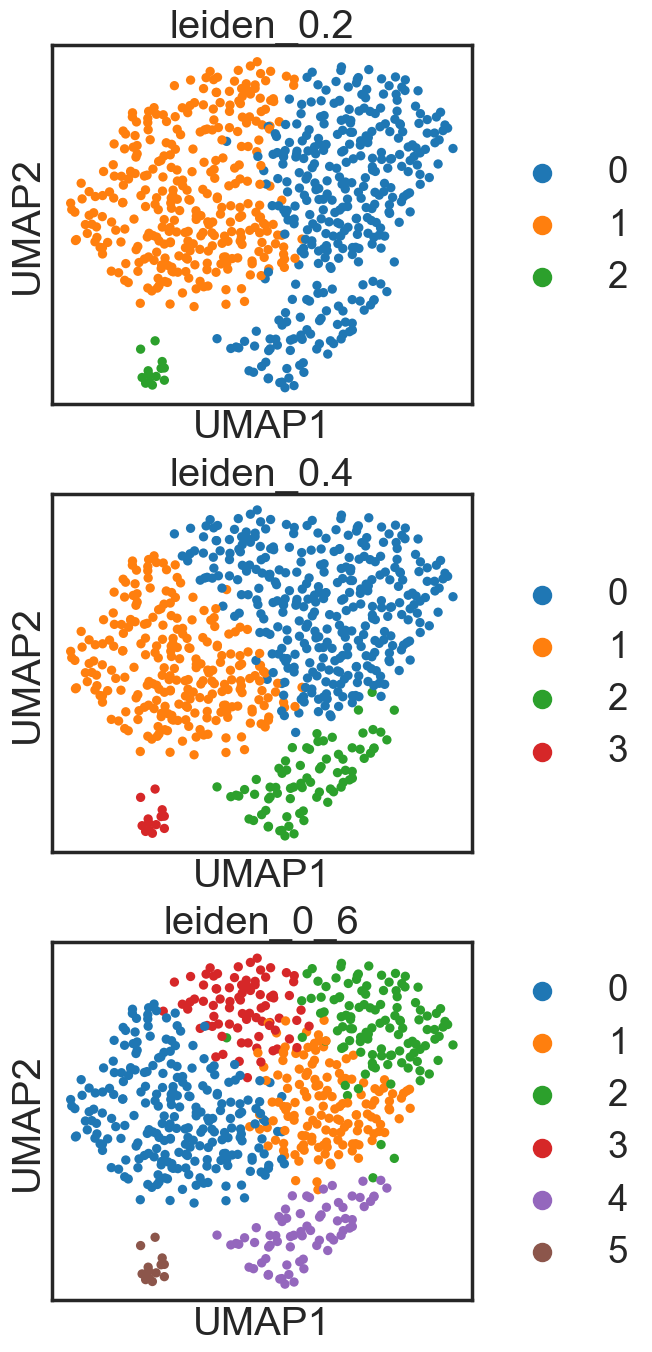

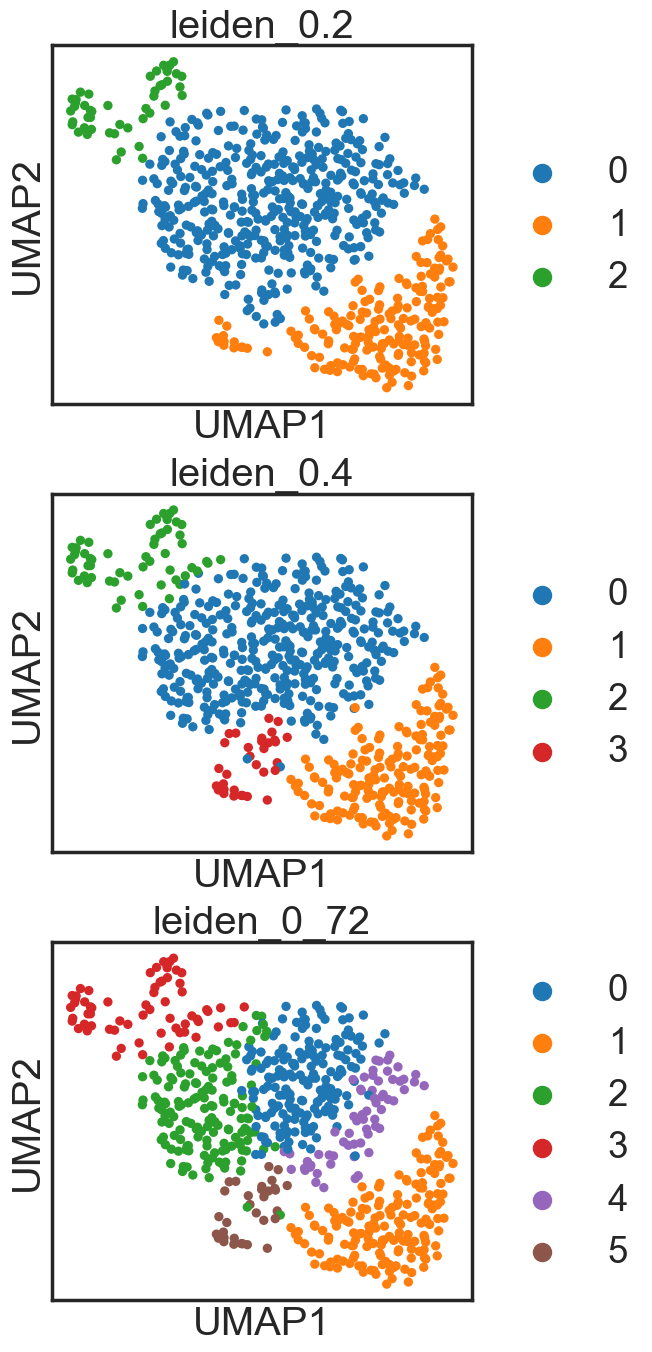

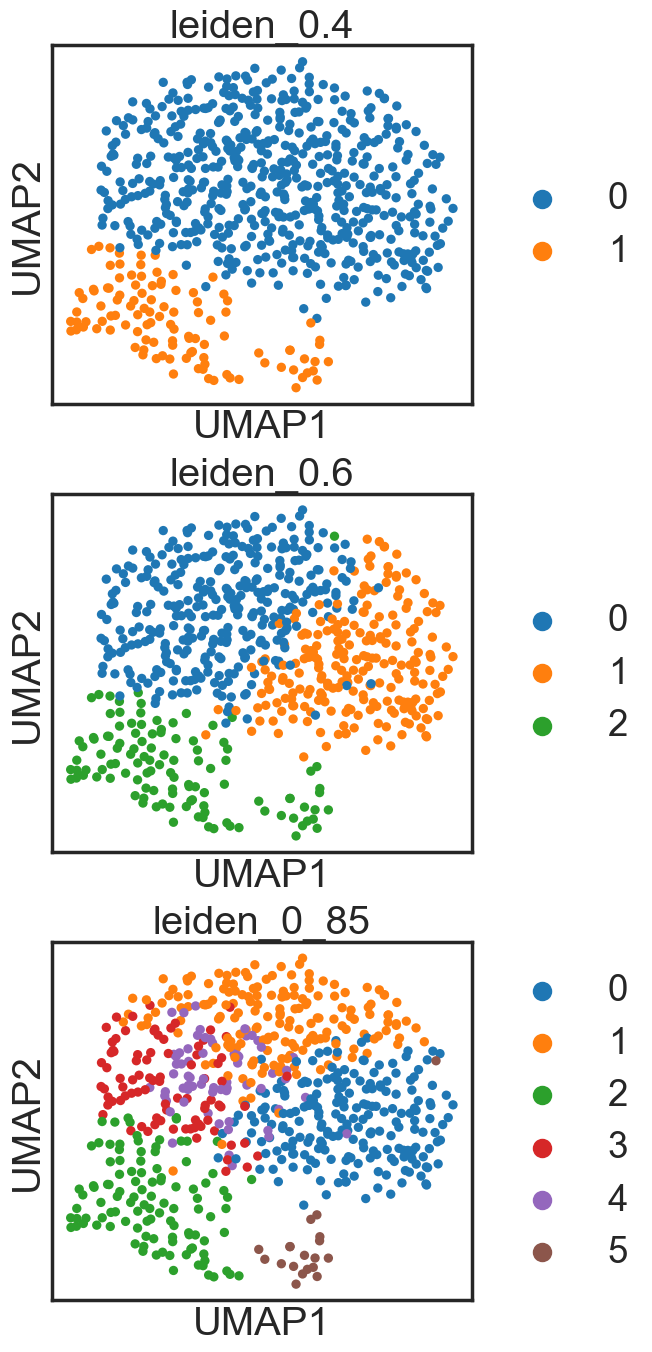

In [53]:
#Showing results in UMAPs

sns.set(style='white', font_scale = 1.2, context='poster', rc={'figure.figsize':(5,5)})


sc.pl.umap(adata_latent, color=['leiden_0.2', 'leiden_0.4', 'leiden_0_6'], ncols =1)
sc.pl.umap(adata_adt, color=['leiden_0.2', 'leiden_0.4', 'leiden_0_72'], ncols =1)
sc.pl.umap(adata_gex, color=['leiden_0.4', 'leiden_0.6', 'leiden_0_85'], ncols =1)

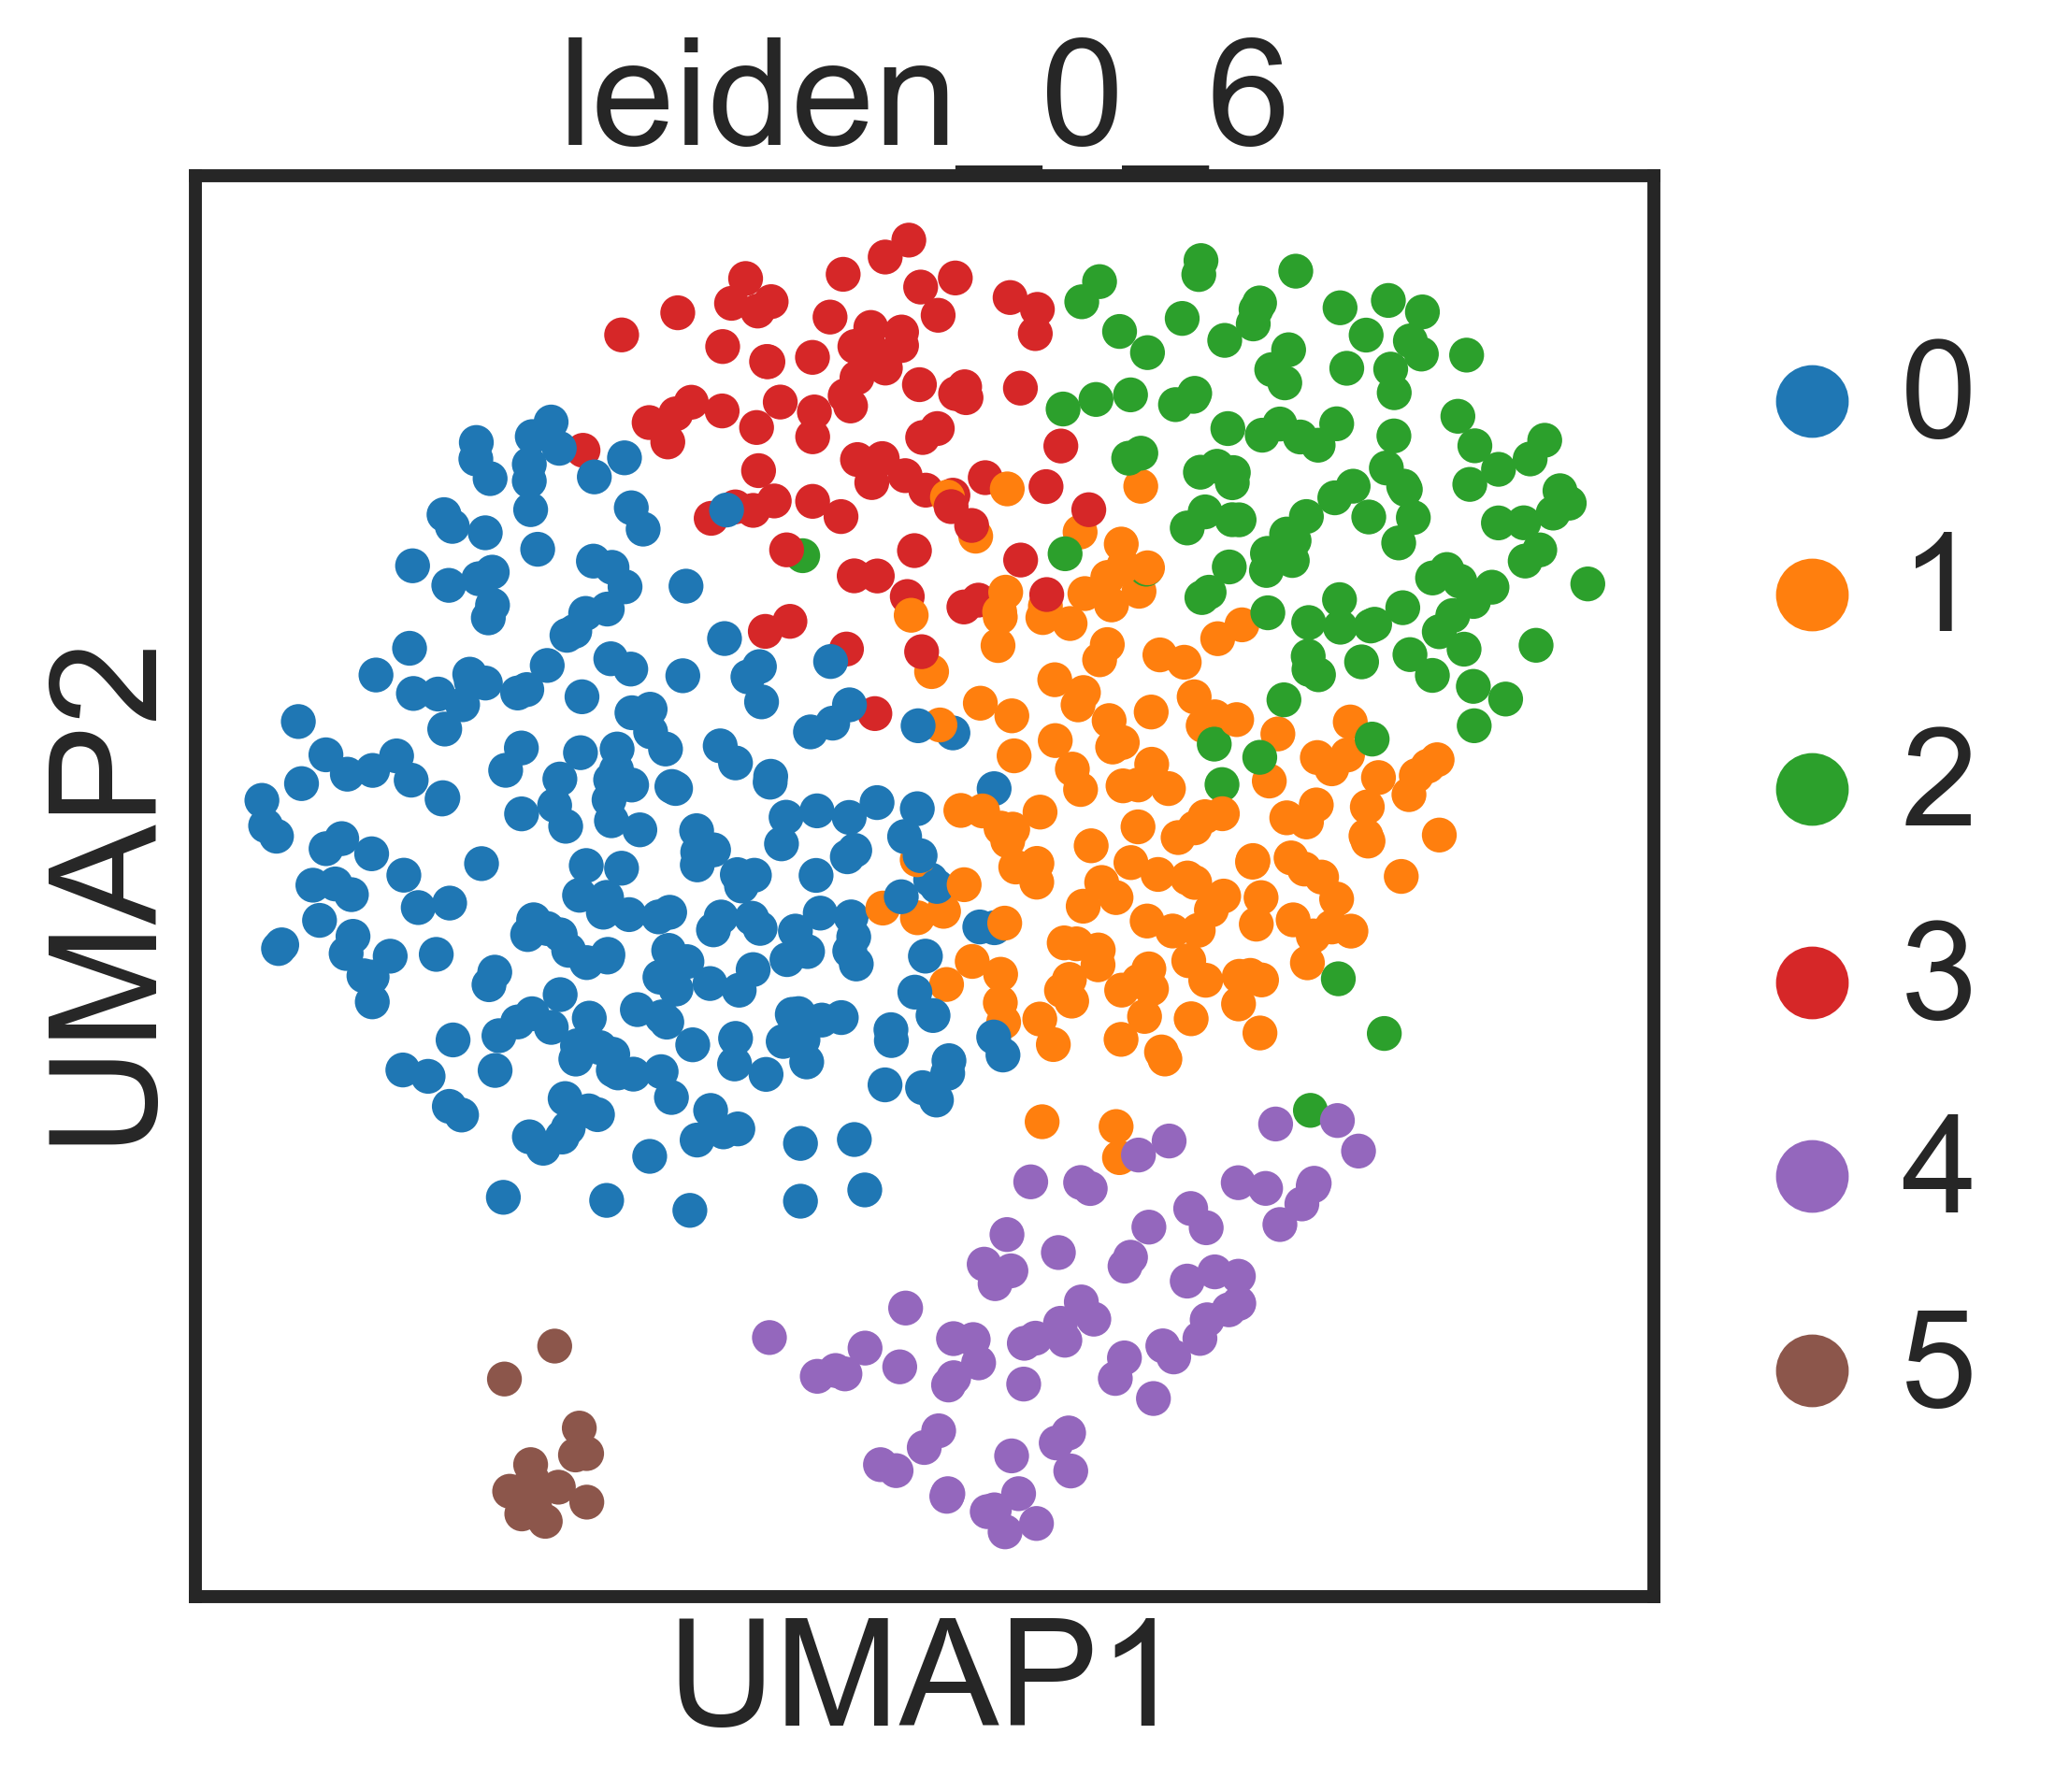

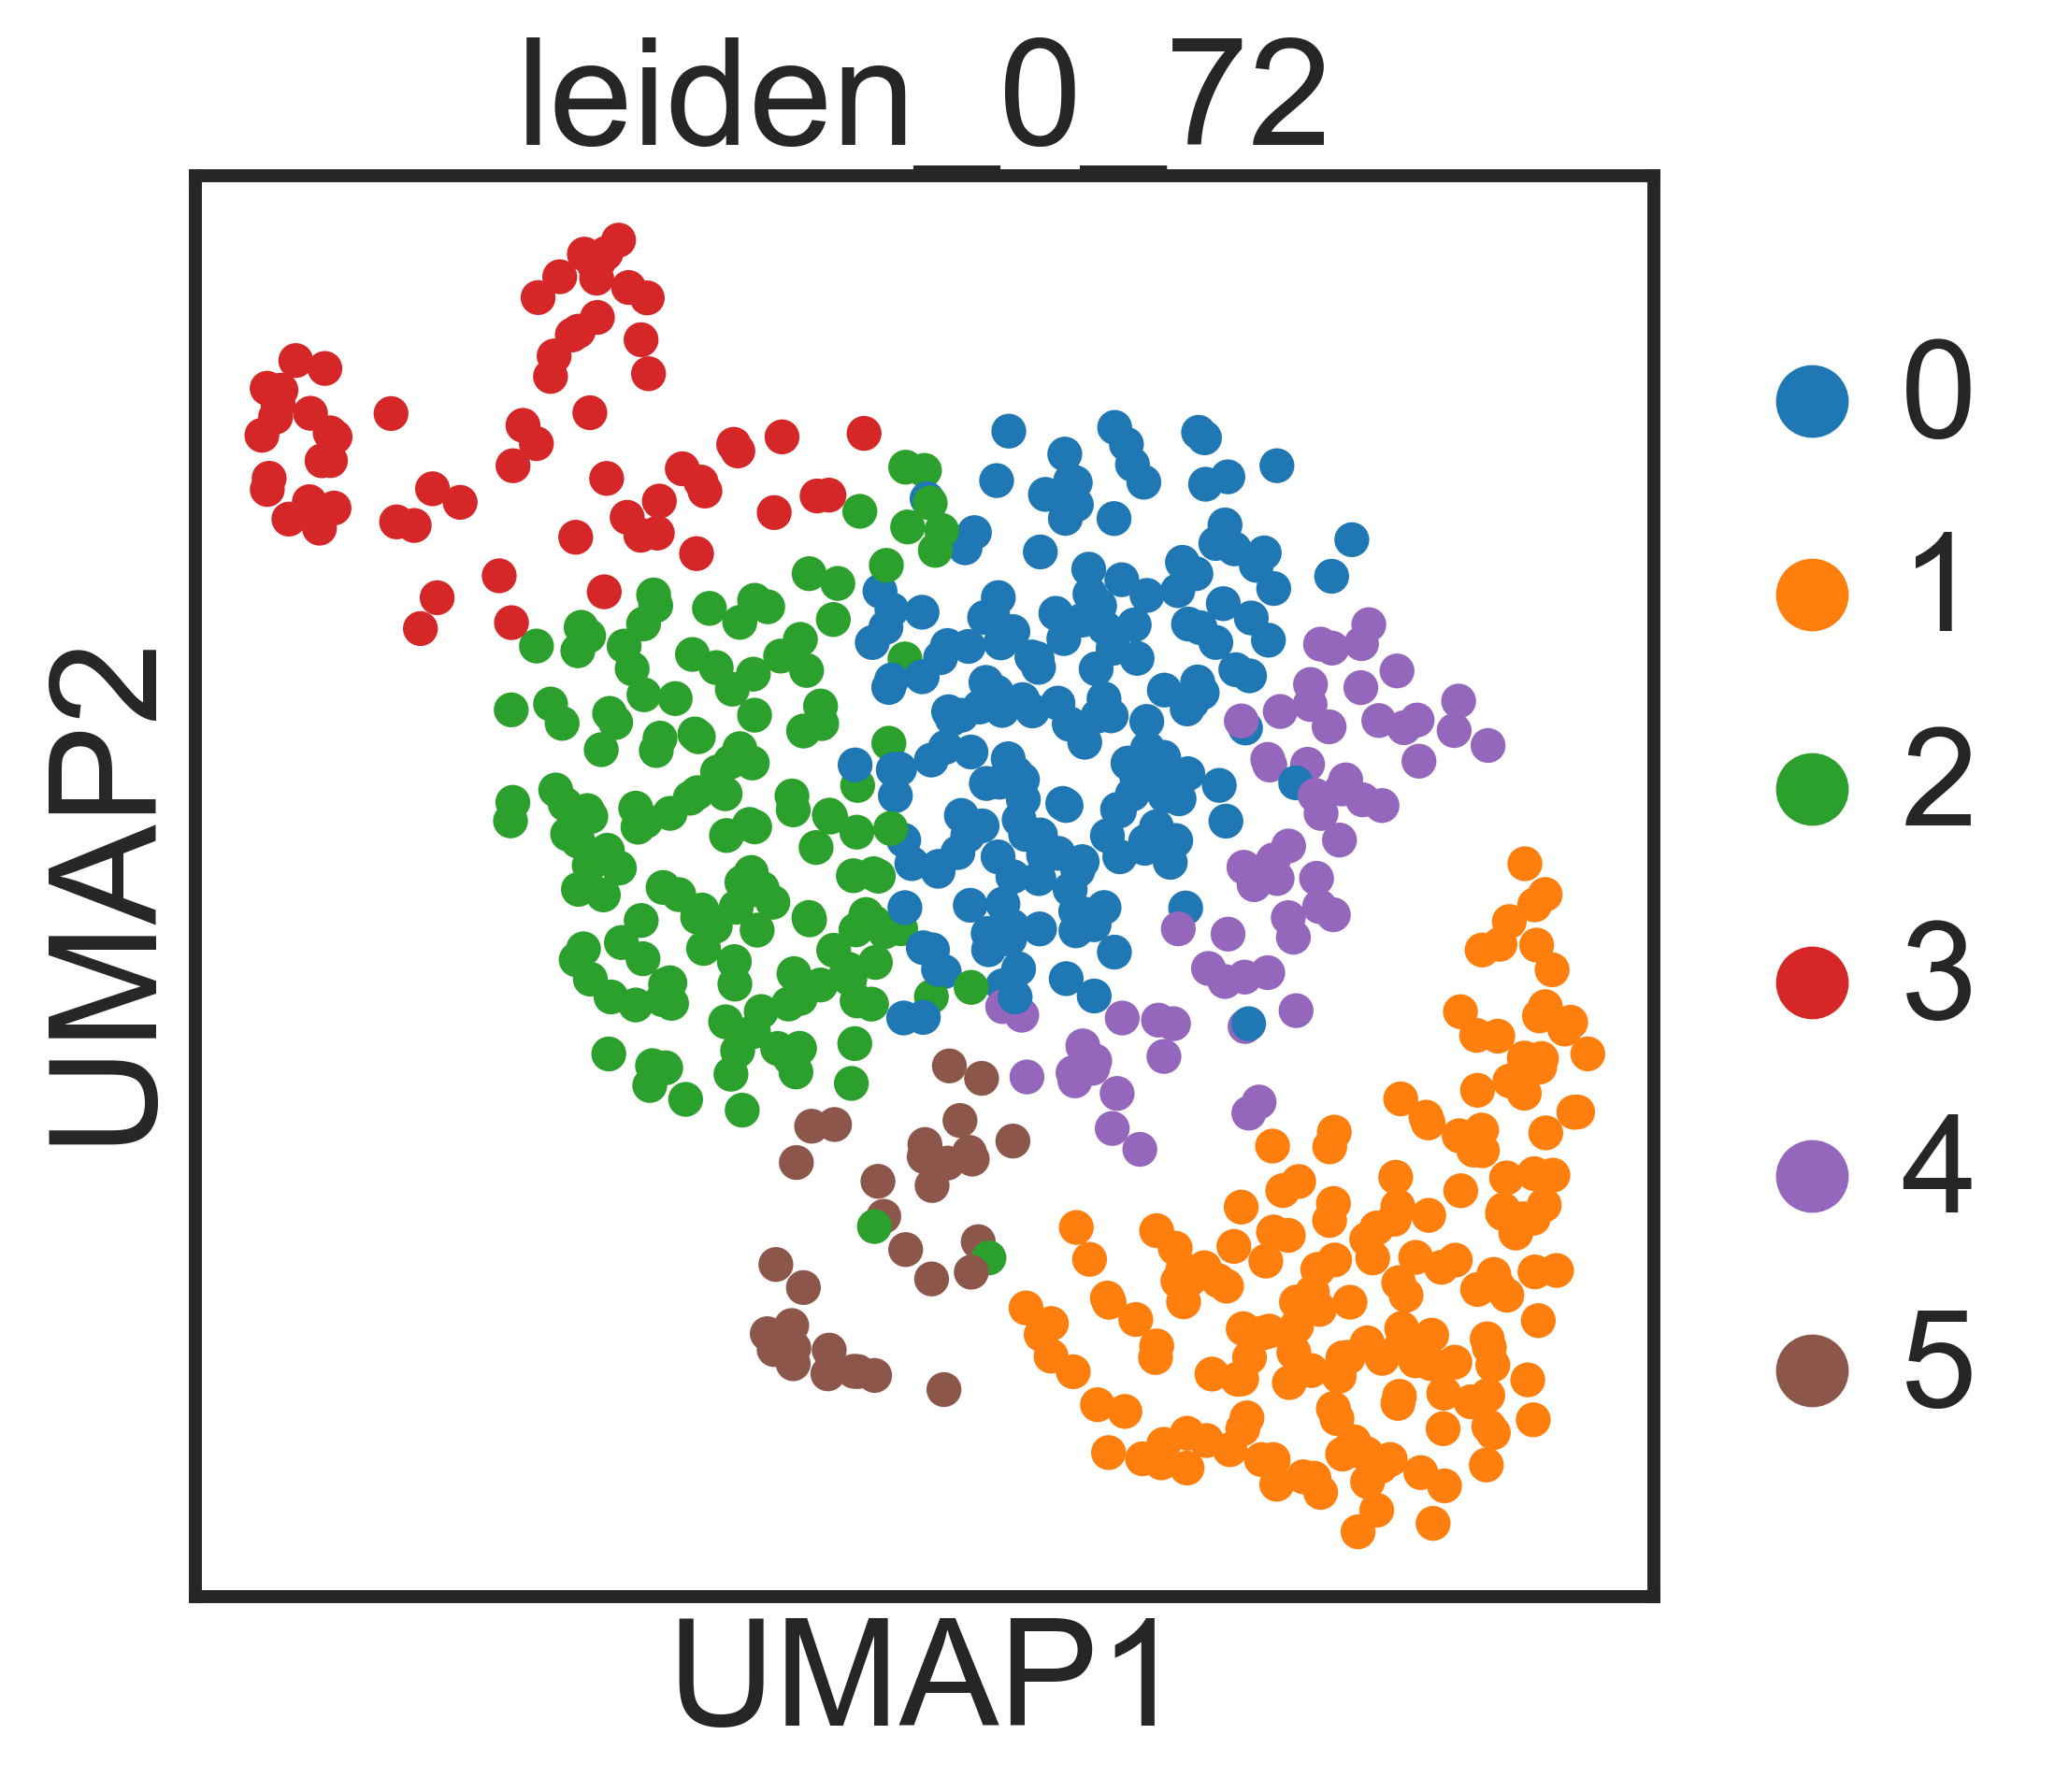

latent vs. protein


In [66]:
#Latent vs prot

sns.set(style='white', font_scale = 1.2, context='poster', rc={'figure.figsize':(5,5)})


sc.pl.umap(adata_latent, color=['leiden_0_6'])
sc.pl.umap(adata_adt, color=['leiden_0_72'])

print('latent vs. protein')

colors = {
    "0": "#1874CD",
    "1": "#FF8C00",
    "2": "Green",
    "3": "Red",
    "4": "#AB82FF",
    "5": "#8A360F"
}


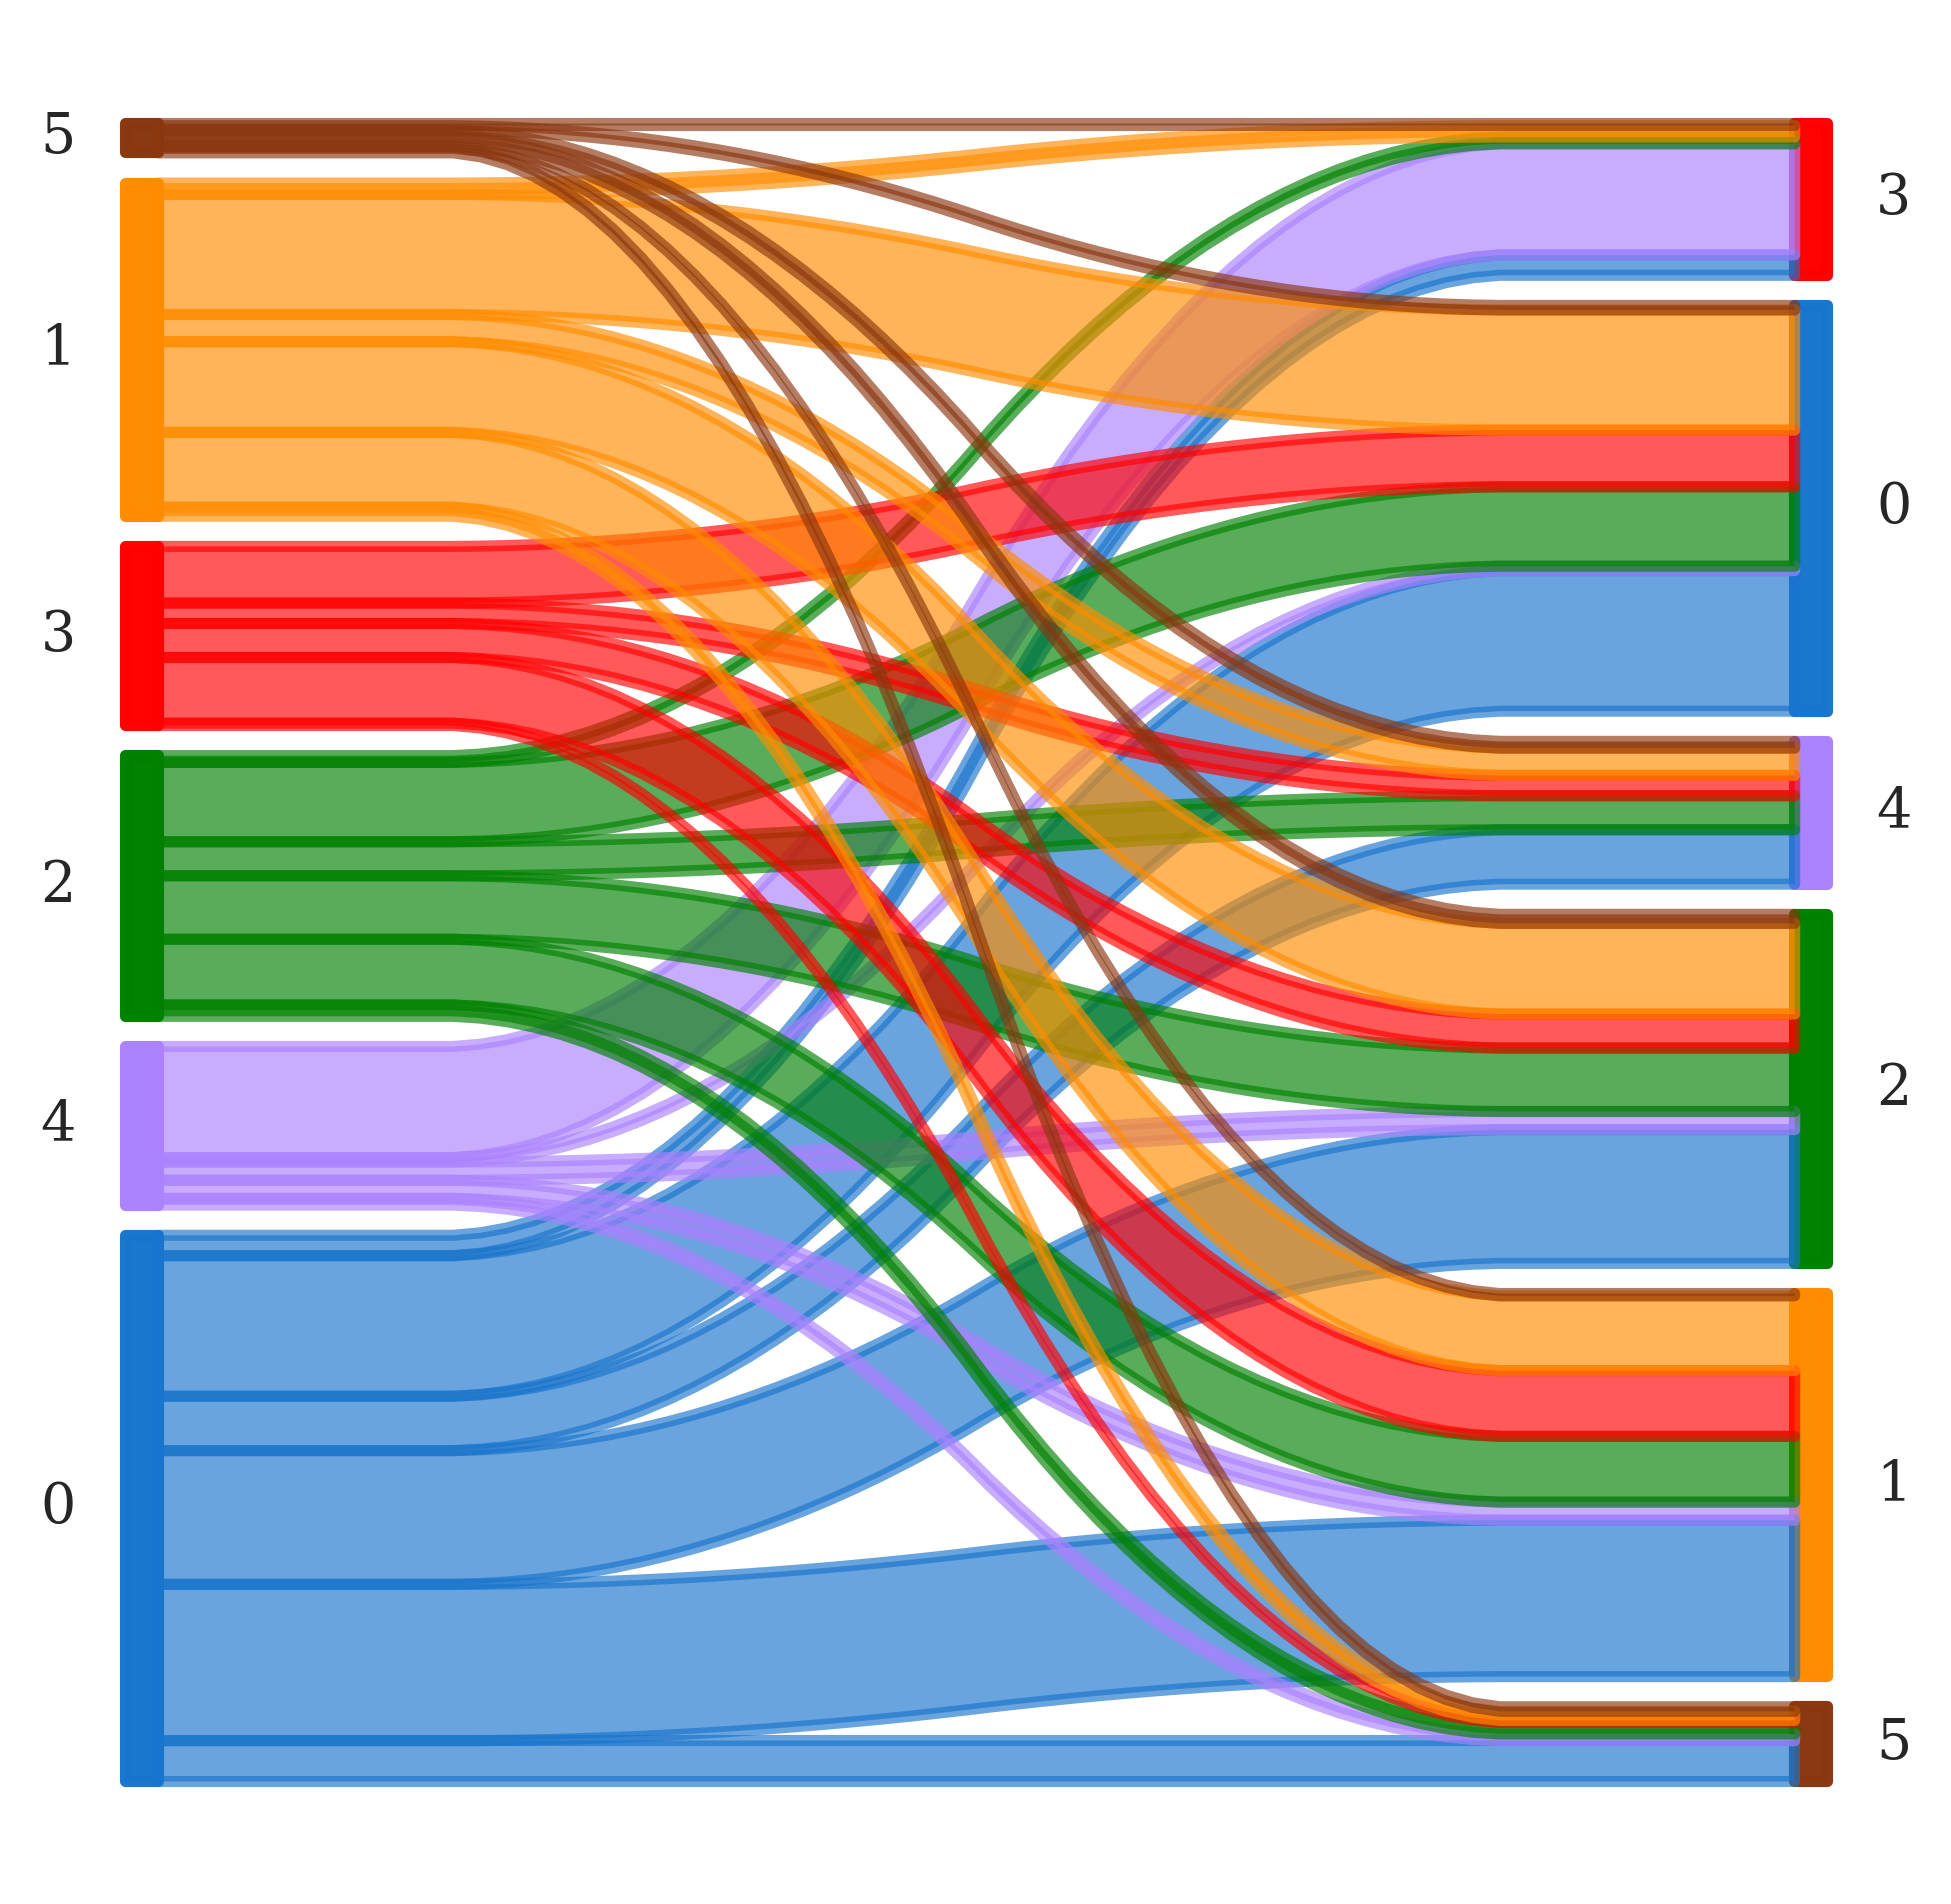

In [68]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=200, dpi_save=300, vector_friendly=True)

sankey.sankey(adata_latent.obs.leiden_0_6, adata_adt.obs.leiden_0_72, colorDict=colors, aspect=20, fontsize=10)

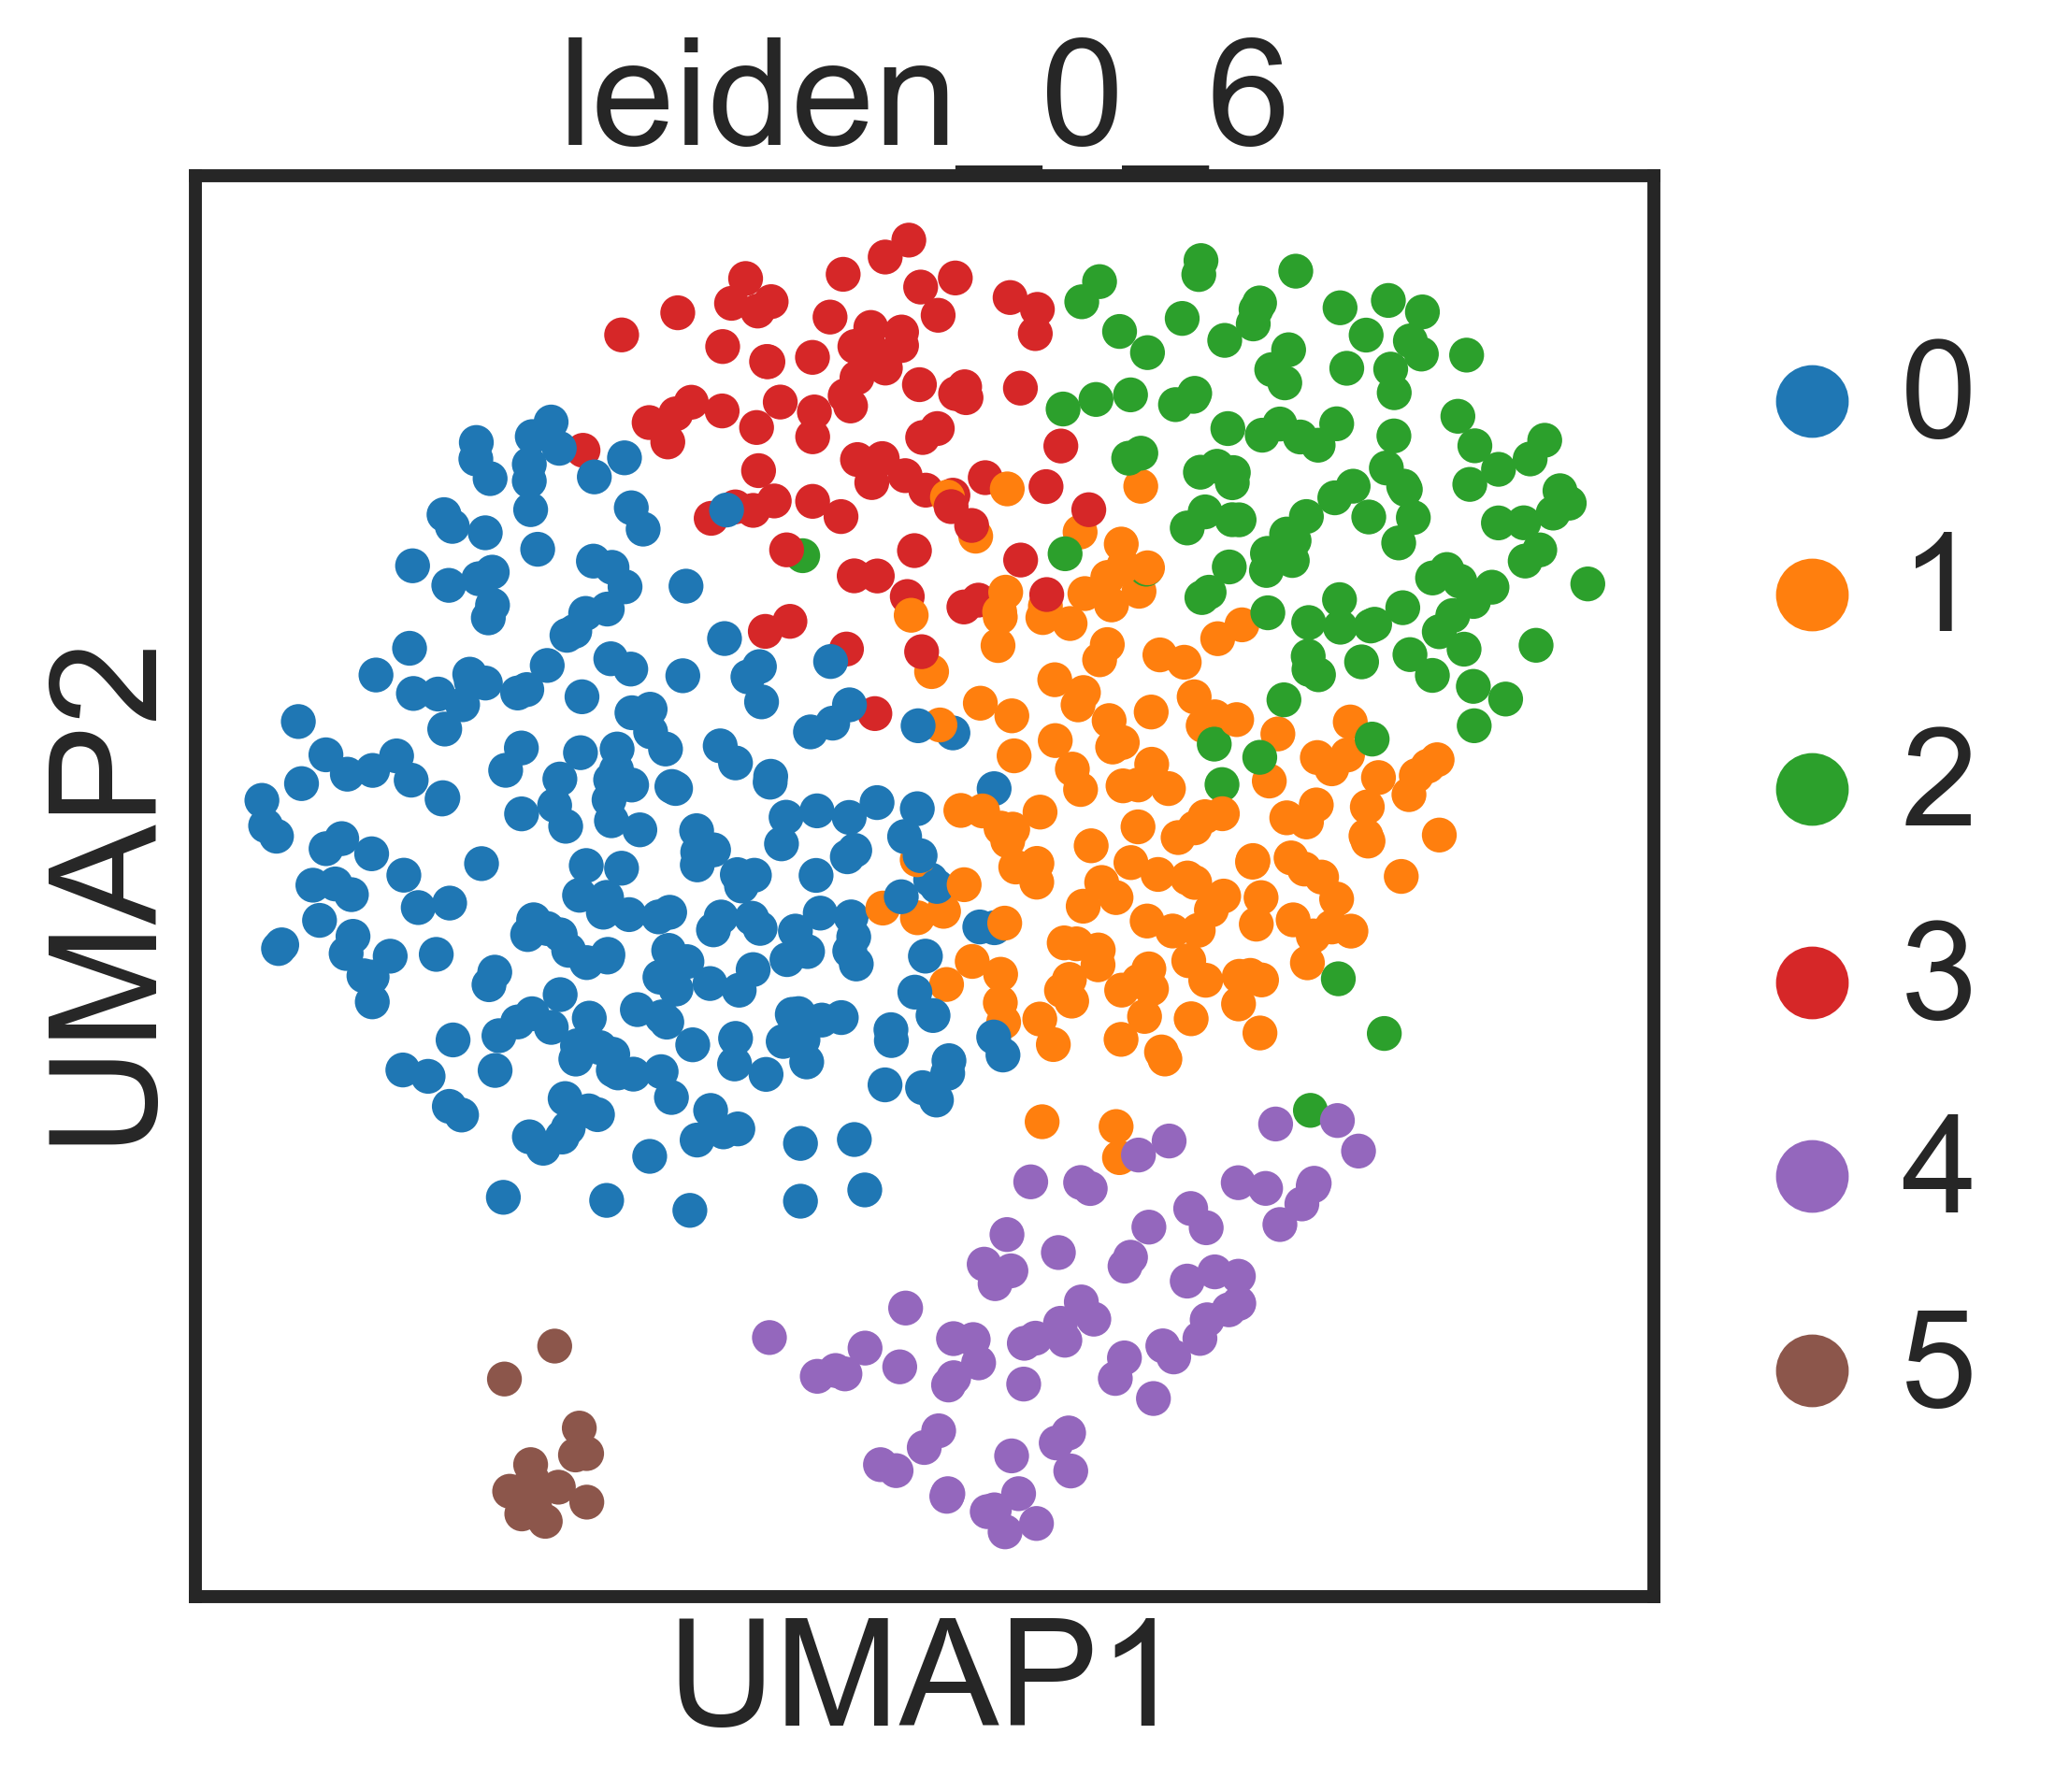

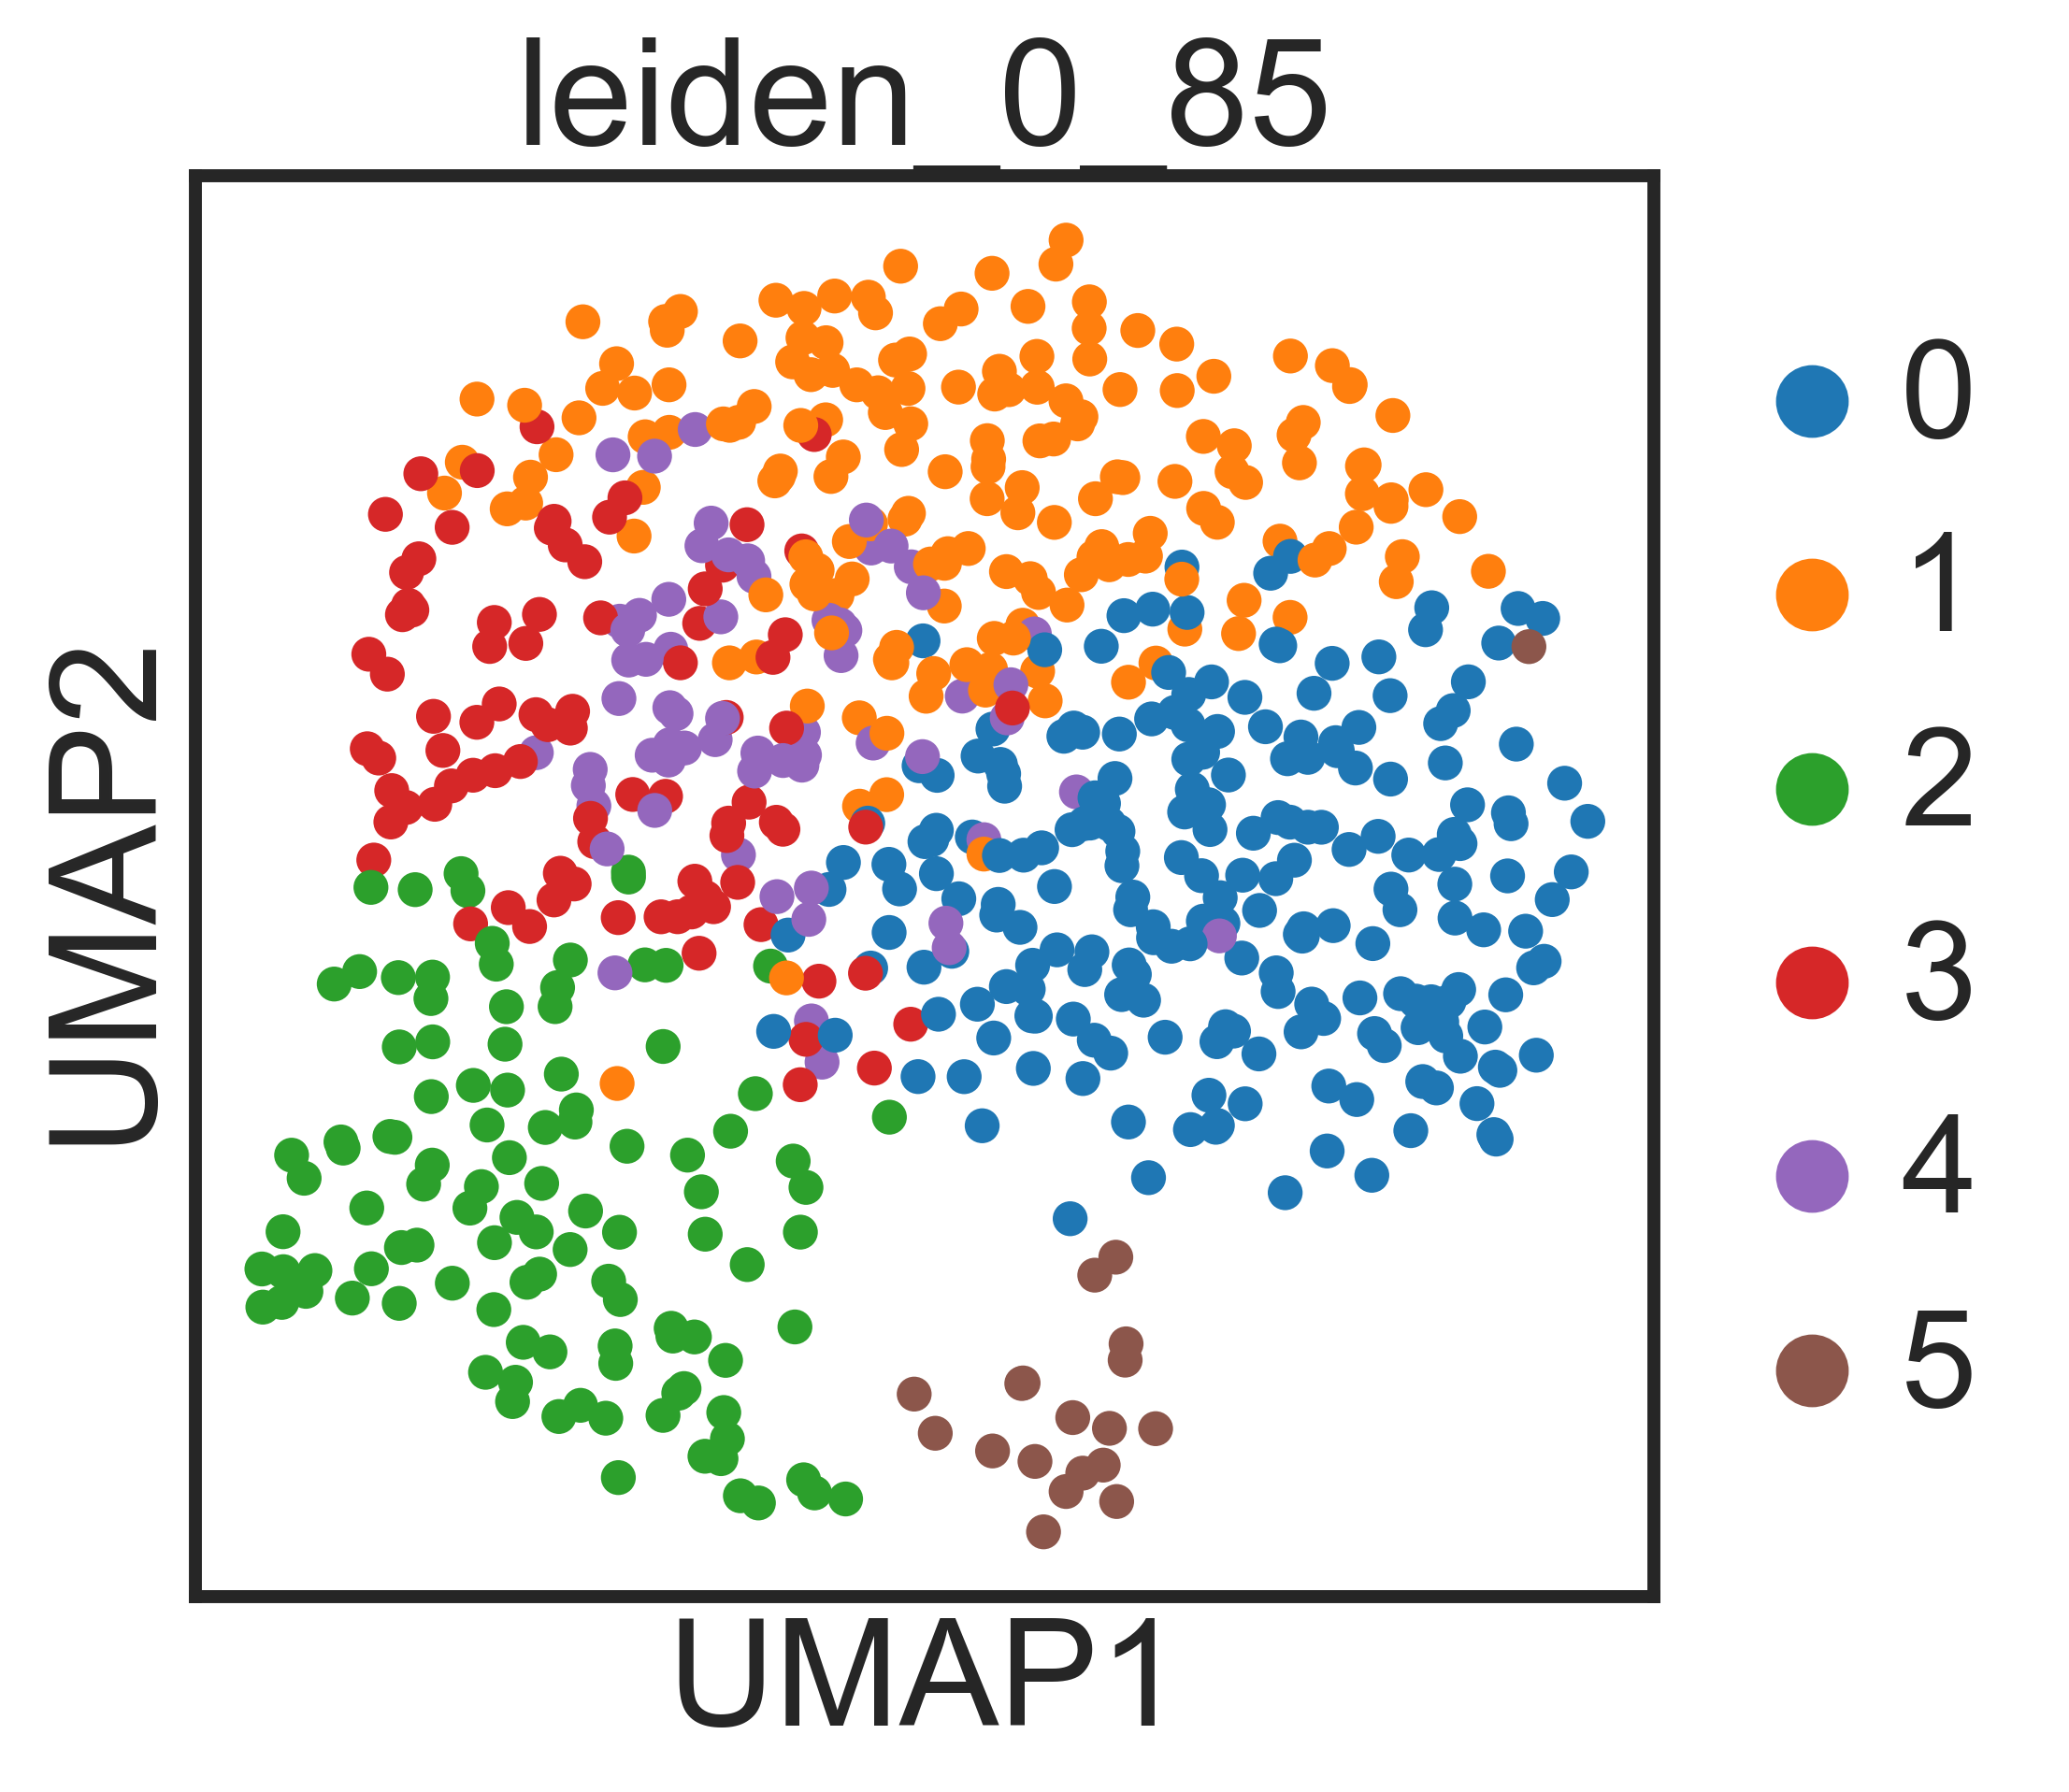

In [67]:
#Latent vs RNA

sns.set(style='white', font_scale = 1.2, context='poster', rc={'figure.figsize':(5,5)})


sc.pl.umap(adata_latent, color=['leiden_0_6'])
sc.pl.umap(adata_gex, color=['leiden_0_85'])


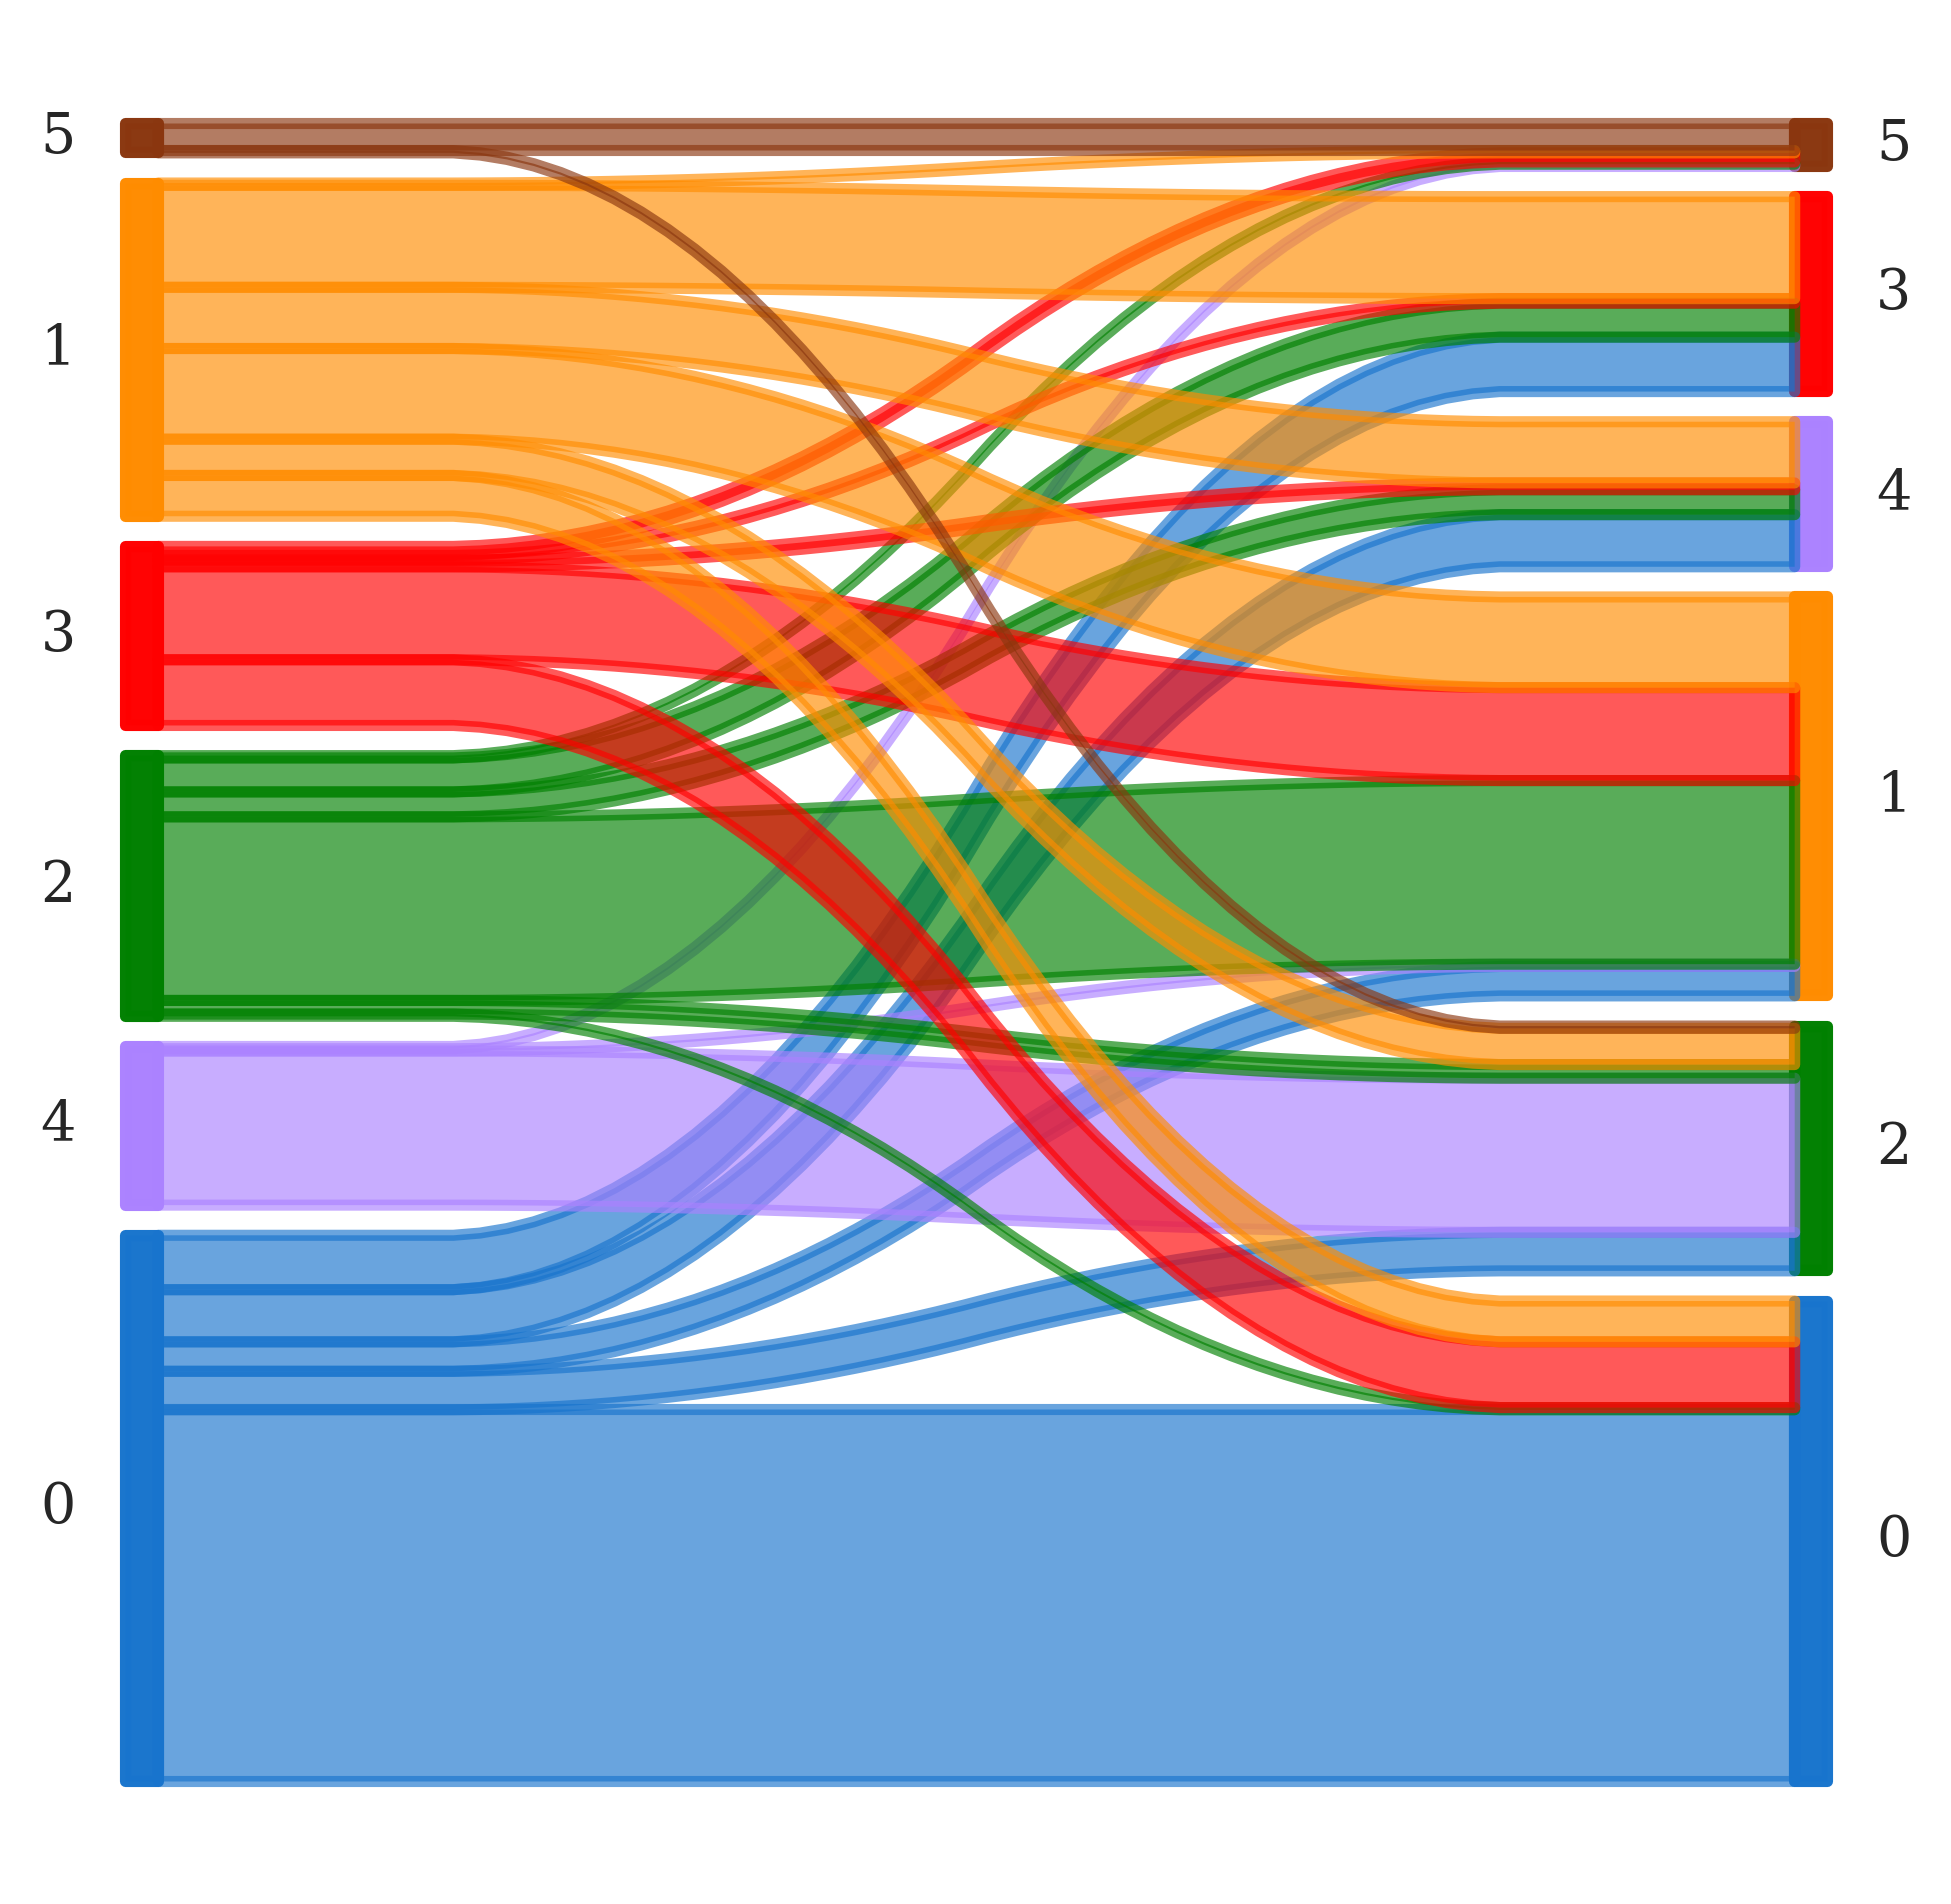

In [69]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=200, dpi_save=300, vector_friendly=True)

sankey.sankey(adata_latent.obs.leiden_0_6, adata_gex.obs.leiden_0_85, colorDict=colors, aspect=20, fontsize=10)

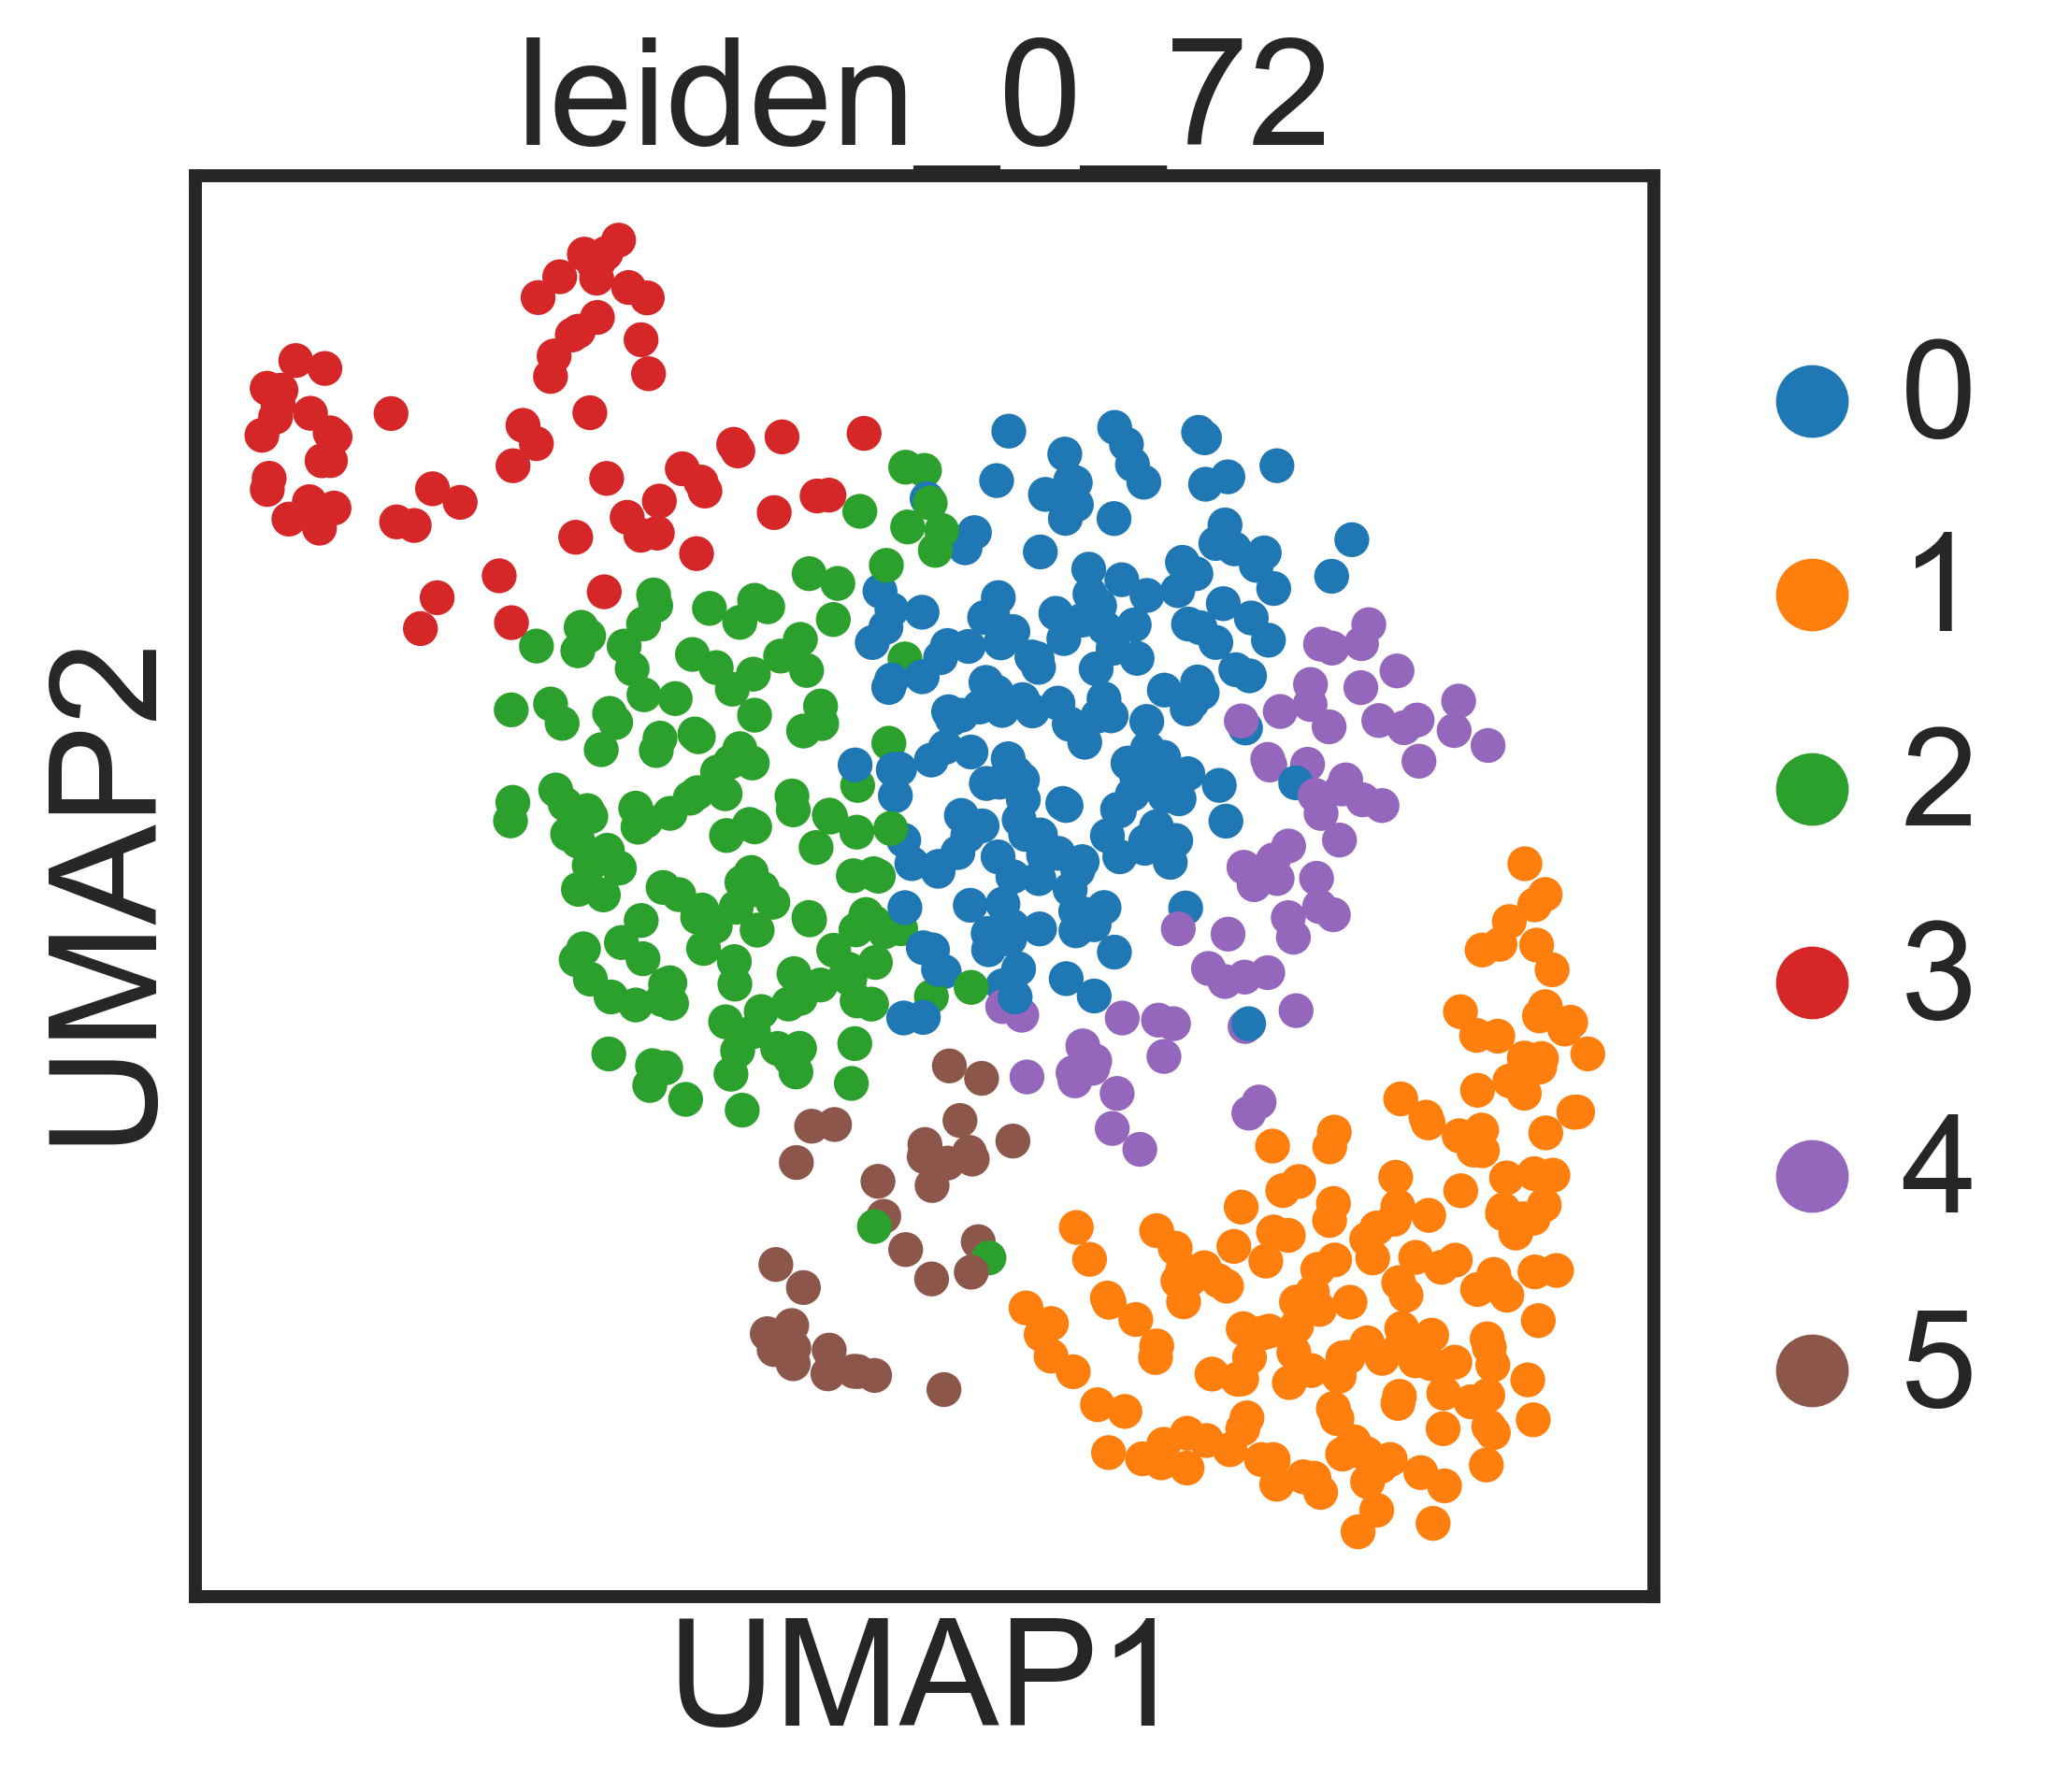

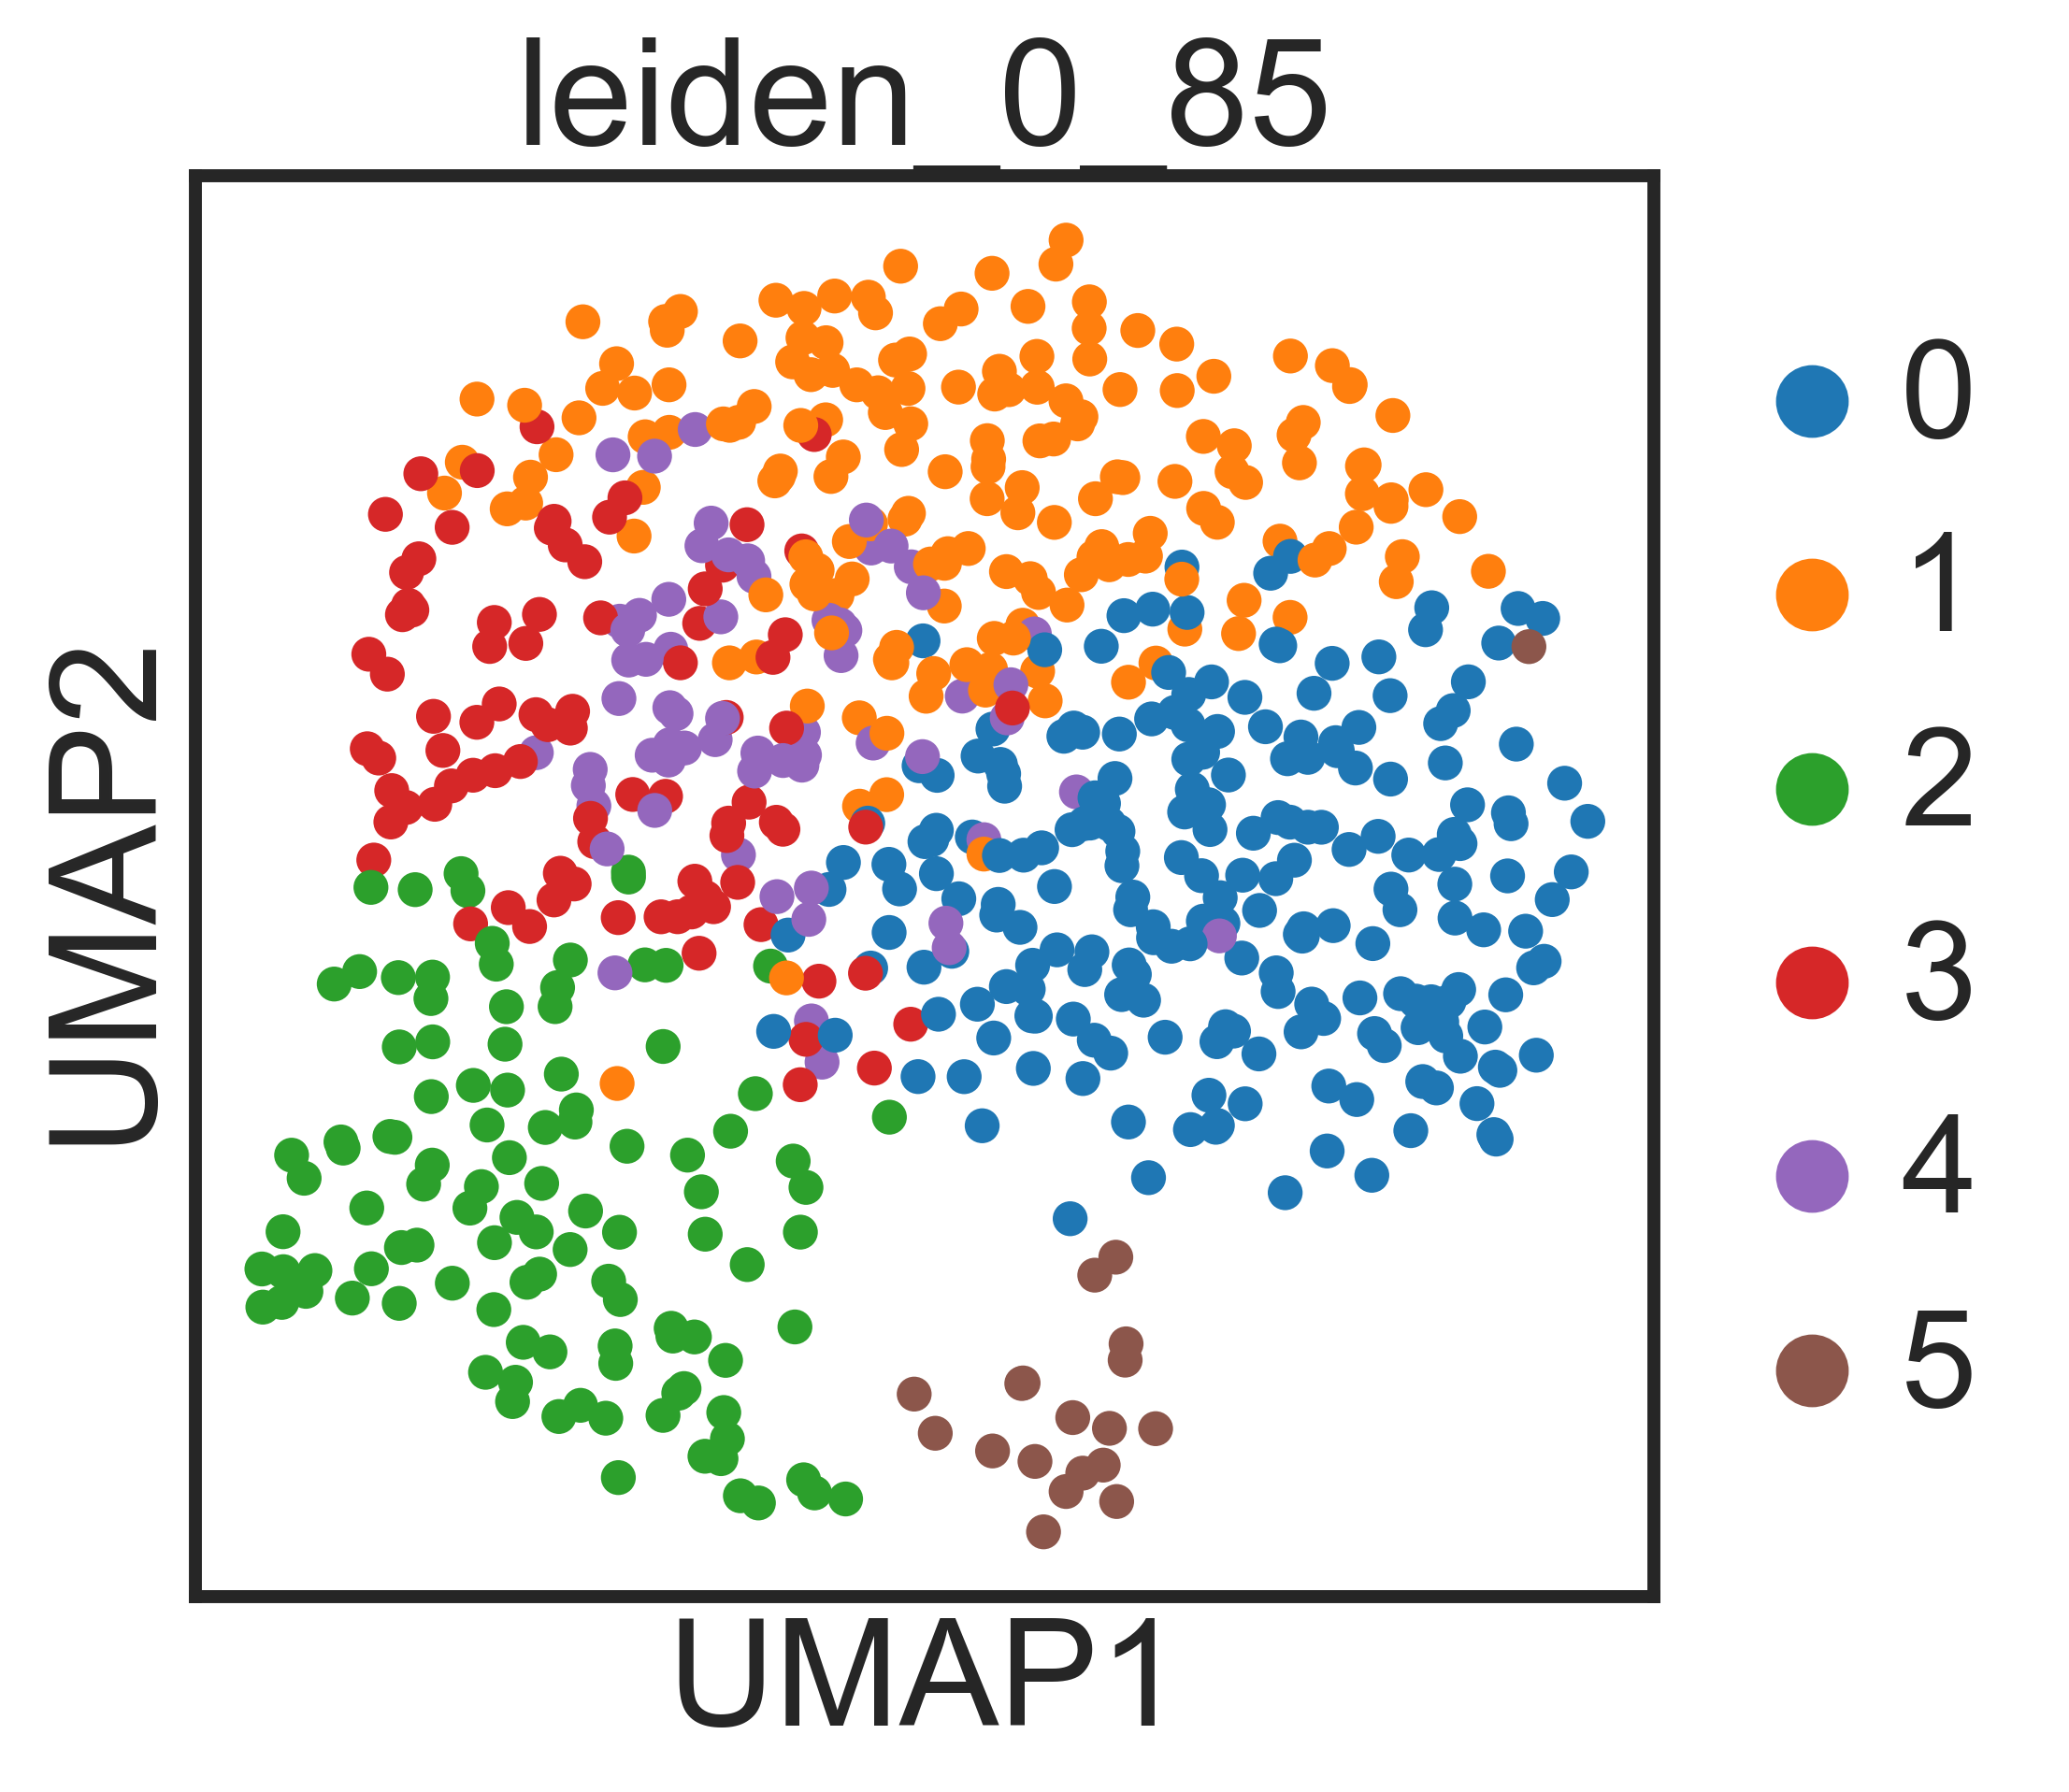

In [70]:
#prot vs rna

sns.set(style='white', font_scale = 1.2, context='poster', rc={'figure.figsize':(5,5)})

sc.pl.umap(adata_adt, color=['leiden_0_72'])
sc.pl.umap(adata_gex, color=['leiden_0_85'])


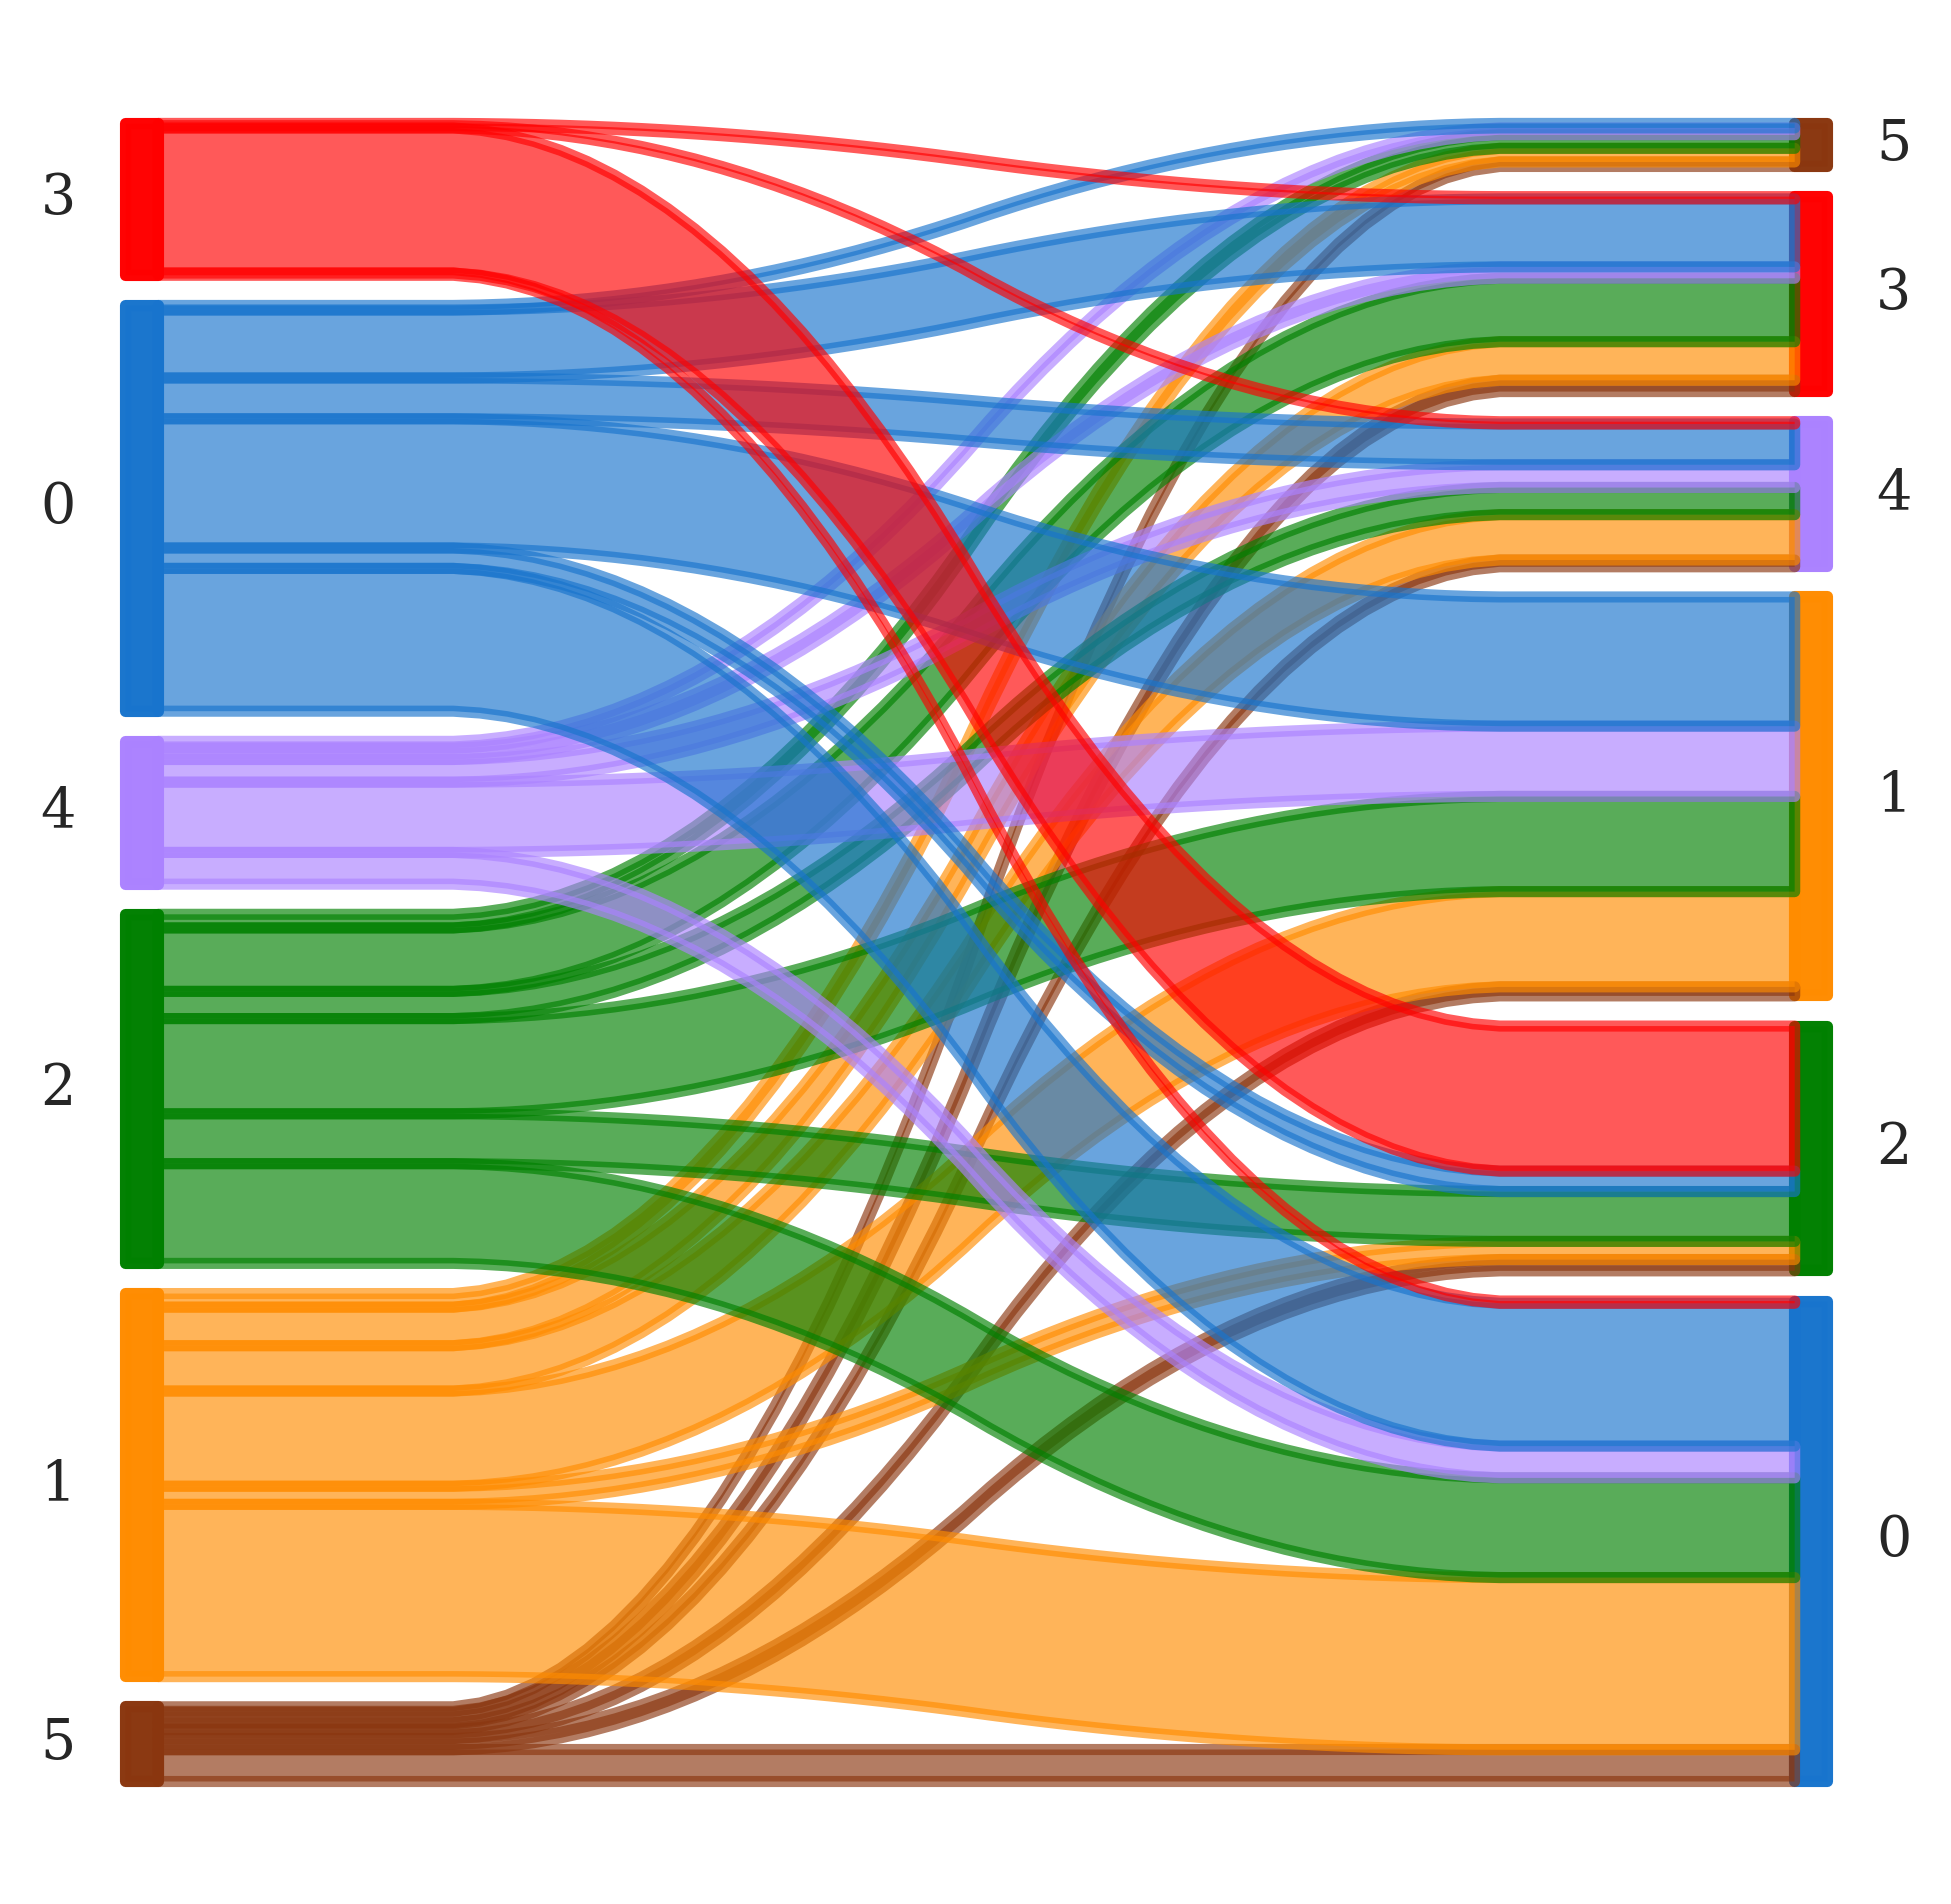

In [71]:

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=200, dpi_save=300, vector_friendly=True)

sankey.sankey(adata_adt.obs.leiden_0_72, adata_gex.obs.leiden_0_85, colorDict=colors, aspect=20, fontsize=10)